<a href="https://colab.research.google.com/github/BlueNyang/AI_Learning_Colab/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TransferLearning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**import**

In [ ]:
import numpy as np
import tensorflow as tf
import pickle
import pandas as pd
import os
from os.path import exists

from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D as GAP
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, BackupAndRestore, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator as IDG

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

##**default**

* **change default directory**

In [ ]:
os.chdir('/content/drive/MyDrive/AI_Lecture/')

* **default loss = tensorflow.keras.losses.categorical_crossentropy**

In [ ]:
ls = losses.categorical_crossentropy

* **model list**

In [ ]:
models=['xception','resnet50','resnet152v2','inceptionv3','densenet121','densenet201','nasnetlarge','efficientnetv2l']
colors=['red','green','blue','yellow','purple','orange','pink','cyan']

* **define callbacks**

In [ ]:
def set_callback(model_name):
    chkp=ModelCheckpoint(f'TransferLearning/{model_name}.h5', monitor='loss',
                         verbose=1, save_best_only=True, mode='min')
    bkup=BackupAndRestore(f'TransferLearning/tmp',
                          save_freq='epoch', delete_checkpoint=True)
    csvl=CSVLogger(f'TransferLearning/{model_name}.csv', separator=',', append=True)
    estp=EarlyStopping(monitor='loss', min_delta=0.005, patience=5,verbose=1,
                       mode='min',restore_best_weights=True, start_from_epoch=20)
    return [chkp, bkup, csvl, estp]

* **Image Generator**

In [ ]:
def image_gen_with_aug(pp_input, data_dir, image_size=224):
    data_gen_with_aug = IDG(preprocessing_function = pp_input, horizontal_flip = True,
                            width_shift_range = 0.2, height_shift_range = 0.2,
                            rotation_range = 30, zoom_range = 0.2)

    data_gen = data_gen_with_aug.flow_from_directory(
        directory = data_dir, target_size = (image_size, image_size),
        batch_size = 12, class_mode = 'categorical')


    return data_gen

In [ ]:
def image_gen_no_aug(pp_input, data_dir, image_size=224):
    data_gen_no_aug = IDG(preprocessing_function = pp_input)

    data_gen = data_gen_no_aug.flow_from_directory(
        directory = data_dir, target_size = (image_size, image_size),
        class_mode = 'categorical')

    return data_gen

* **model compiling**

In [ ]:
def compile_model(based_model, classes_num):
    cnn = Sequential()
    cnn.add(based_model)
    cnn.add(GAP())
    cnn.add(Dense(1024, activation = 'relu'))
    cnn.add(Dense(classes_num, activation = 'softmax'))

    cnn.compile(loss=ls, optimizer = Adam(0.0001), metrics = ['accuracy'])

    return cnn

* **save and load**

In [ ]:
def save_validations(data_name, model_name, result):
    if exists(f'TransferLearning/{data_name}.pkl') == False:
        pickle.dump(None, open(f'TransferLearning/{data_name}.pkl','wb'))

    data=pickle.load(open(f'TransferLearning/{data_name}.pkl', 'rb'))
    if data == None:
        data={}

    data.update({f'{model_name}':result})

    with open(f'TransferLearning/{data_name}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
def get_validations(data):
    with open(f'TransferLearning/{data}.pkl', 'rb') as f:
        data=pickle.load(f)

    return data

In [ ]:
def get_hist(model_name):
    with open(f'TransferLearning/{model_name}.csv', 'rb') as f:
        temp=pd.read_csv(f)
    return temp

In [ ]:
def get_cnn(model_name, new_cnn):
    new_cnn.load_weights(f'TransferLearning/{model_name}.h5')
    new_cnn.summary()

* **plt**

In [ ]:
def show_hist_graph(fit_hist, model_name, fig_size = (13, 5), title='Result'):
    plt.figure(figsize=fig_size)
    plt.suptitle(title)

    plt.subplot(1,2,1)
    plt.plot(fit_hist['accuracy'])
    plt.plot(fit_hist['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(fit_hist['loss'])
    plt.plot(fit_hist['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid()

    plt.savefig(f'TransferLearning/Graphs/{model_name}.png')

    plt.show()

In [ ]:
def show_model_comparison(hist_list, color_list, model_list, data_name, fig_size=(15,10)):
    plt.figure(figsize=fig_size)
    plt.suptitle('Model hist Comparison')

    length = len(hist_list)

    component=[['Accuracy','Validation Accuracy','Loss','Validation Loss'],
               ['accuracy','val_accuracy','loss','val_loss']]

    for i in range(4):
        plt.subplot(2,2,(i+1))
        for j in range(length):
            plt.plot(hist_list[j][component[1][i]], color=color_list[j],
                     linestyle='-', marker=',')
        plt.title(f'Model {component[0][i]}')
        plt.xlabel('Epoch')
        plt.ylabel(component[0][i])
        plt.legend(model_list, loc='best')
        plt.grid()

    plt.savefig(f'TransferLearning/Graphs/{data_name}_model_comparison.png')

    plt.show()

In [ ]:
def show_accuracy_comparison(data_name, model_list, color_list, hist_list, fig_size=(13,5)):
    data=get_validations(data_name)
    x = np.arange(len(model_list))

    plt.figure(figsize=fig_size)

    plt.suptitle('Accuracy Comparison')

    plt.subplot(1,2,1)
    plt.title('Model Accuracy')
    data_values=[]
    for i, m in enumerate(model_list):
        m_name=f'{data_name}_{m}'
        data_values.append(data[m_name])
        plt.text(i+1, np.max(data[m_name]), f'{round(np.mean(data[m_name])*100, 2)}%',
                 color='black', horizontalalignment='center', verticalalignment='bottom',
                 fontweight='bold')

    plt.boxplot(data_values,showmeans=True)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(x+1, model_list, rotation=45)
    plt.grid()

    plt.subplot(1,2,2)
    plt.title('Epochs')
    epoch=[]
    for i in x:
        epoch.append(len(hist_list[i]['accuracy']))
    plt.bar(x, epoch, color=color_list, width = 0.8)
    plt.xlabel('Model')
    plt.ylabel('Epochs')
    plt.xticks(x, model_list, rotation=45)
    for i, v in enumerate(x):
        plt.text(i, epoch[i], epoch[i], color='black', horizontalalignment='center', verticalalignment='bottom',
                fontweight='bold')
    plt.grid()

    plt.savefig(f'TransferLearning/Graphs/{data_name}_acc_comparison.png', dpi=300,
                facecolor='white', edgecolor='black', orientation='portrait',
                format='png', transparent=False, bbox_inches='tight', pad_inches=0.1)

    plt.show()

#**A. CUB200**

In [ ]:
train_dir = 'CUB200/train'
val_dir = 'CUB200/val'
data_name='cub200'

In [ ]:
images_size=224
class_number=10

##**A.1. Xception**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_xception'

In [ ]:
base_model=Xception(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

83683744/83683744 [==============================] - 6s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-21-90ead0958d0b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 2.0227 - accuracy: 0.3233
Epoch 1: loss improved from inf to 2.02270, saving model to TransferLearning/cub200_xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 165s 5s/step - loss: 2.0227 - accuracy: 0.3233 - val_loss: 1.1446 - val_accuracy: 0.5967
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.1044 - accuracy: 0.7133
Epoch 2: loss improved from 2.02270 to 1.10437, saving model to TransferLearning/cub200_xception.h5
25/25 [==============================] - 16s 641ms/step - loss: 1.1044 - accuracy: 0.7133 - val_loss: 0.4917 - val_accuracy: 0.8300
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.8233
Epoch 3: loss improved from 1.10437 to 0.57796, saving model to TransferLearning/cub200_xception.h5
25/25 [==============================] - 17s 675ms/step - loss: 0.5780 - accuracy: 0.8233 - val_loss: 0.2240 - val_accuracy: 0.9167
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3260 - accuracy: 0.9033
Epoch 4: loss improved from 0.57796 to 0.32598, saving model to TransferLearning/cub200_xception.h5
25/25 [=================

* **Assessment**

In [ ]:
#get_cnn(model_name, new_cnn=cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 10)                10250     
                                                                 
Total params: 22969906 (87.62 MB)
Trainable params: 22915378 (87.42 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 210ms/step - loss: 0.0065 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 273ms/step - loss: 0.0156 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 208ms/step - loss: 0.0026 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 272ms/step - loss: 0.0032 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 211ms/step - loss: 0.0041 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

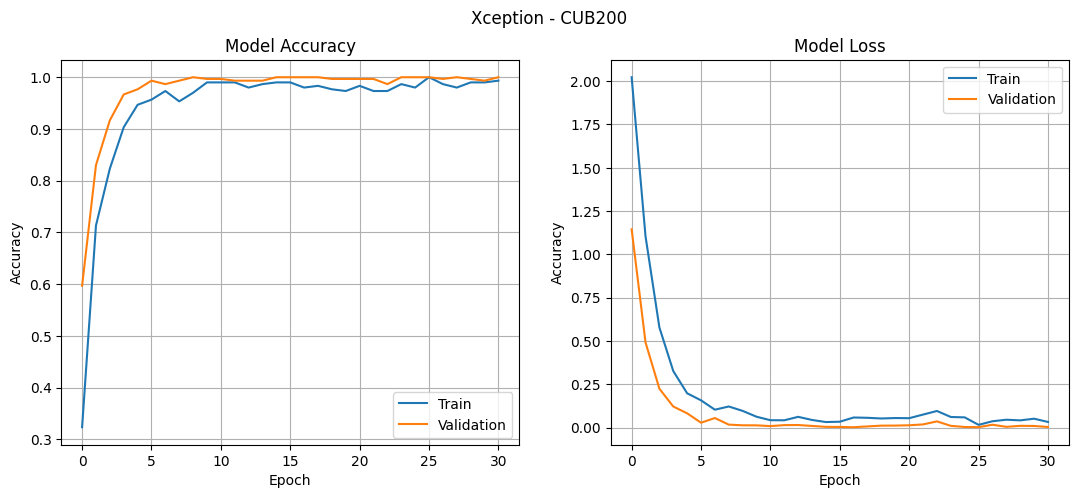

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='Xception - CUB200',)

##**A.2. ResNet50**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_resnet50'

In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

94765736/94765736 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-29-90ead0958d0b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.7633 - accuracy: 0.4233
Epoch 1: loss improved from inf to 1.76332, saving model to TransferLearning/cub200_resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 65s 781ms/step - loss: 1.7633 - accuracy: 0.4233 - val_loss: 0.6573 - val_accuracy: 0.7667
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.5632 - accuracy: 0.8500
Epoch 2: loss improved from 1.76332 to 0.56322, saving model to TransferLearning/cub200_resnet50.h5
25/25 [==============================] - 23s 934ms/step - loss: 0.5632 - accuracy: 0.8500 - val_loss: 0.3981 - val_accuracy: 0.9100
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.2306 - accuracy: 0.9533
Epoch 3: loss improved from 0.56322 to 0.23056, saving model to TransferLearning/cub200_resnet50.h5
25/25 [==============================] - 26s 1s/step - loss: 0.2306 - accuracy: 0.9533 - val_loss: 0.1779 - val_accuracy: 0.9567
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.1627 - accuracy: 0.9533
Epoch 4: loss improved from 0.23056 to 0.16270, saving model to TransferLearning/cub200_resnet50.h5
25/25 [==================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_13 (Dense)            (None, 10)                10250     
                                                                 
Total params: 25696138 (98.02 MB)
Trainable params: 25643018 (97.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 8s 257ms/step - loss: 0.0427 - accuracy: 0.9933
Accuracy is 99.33333396911621%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 204ms/step - loss: 0.0044 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 214ms/step - loss: 0.0073 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 202ms/step - loss: 0.0146 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 257ms/step - loss: 0.0189 - accuracy: 0.9933
Accuracy is 99.33333396911621%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

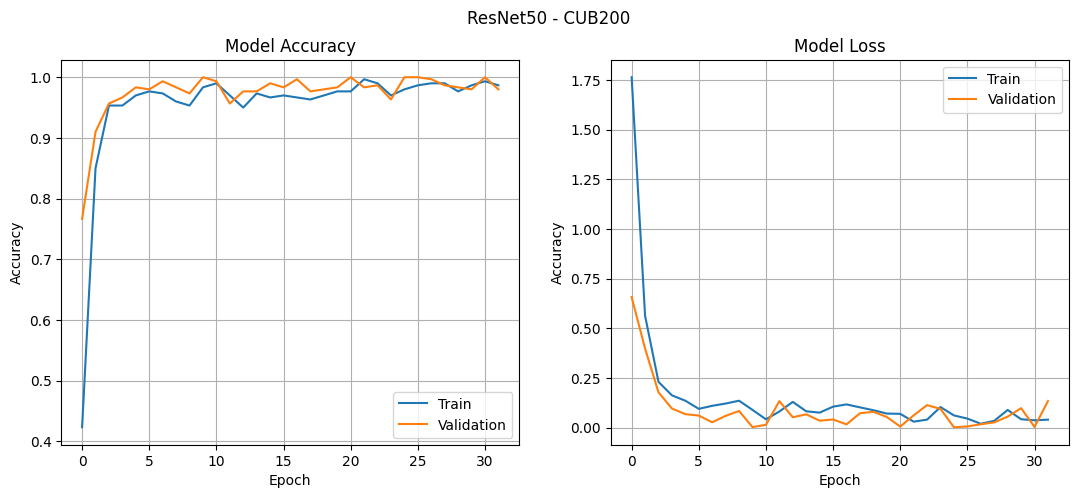

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet50 - CUB200')

##**A.3. ResNet152V2**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_resnet152v2'

In [ ]:
base_model=ResNet152V2(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

234545216/234545216 [==============================] - 1s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-133-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8840 - accuracy: 0.3600
Epoch 1: loss improved from inf to 1.88400, saving model to TransferLearning/cub200_resnet152v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 146s 1s/step - loss: 1.8840 - accuracy: 0.3600 - val_loss: 0.7606 - val_accuracy: 0.7233
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.7900
Epoch 2: loss improved from 1.88400 to 0.76694, saving model to TransferLearning/cub200_resnet152v2.h5
25/25 [==============================] - 47s 2s/step - loss: 0.7669 - accuracy: 0.7900 - val_loss: 0.5508 - val_accuracy: 0.8233
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8833
Epoch 3: loss improved from 0.76694 to 0.44566, saving model to TransferLearning/cub200_resnet152v2.h5
25/25 [==============================] - 51s 2s/step - loss: 0.4457 - accuracy: 0.8833 - val_loss: 0.1938 - val_accuracy: 0.9333
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.2663 - accuracy: 0.9333
Epoch 4: loss improved from 0.44566 to 0.26634, saving model to TransferLearning/cub200_resnet152v2.h5
25/25 [==============

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 17s 671ms/step - loss: 0.0655 - accuracy: 0.9800
Accuracy is 98.00000190734863%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 13s 518ms/step - loss: 0.0458 - accuracy: 0.9900
Accuracy is 99.00000095367432%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 266ms/step - loss: 0.0362 - accuracy: 0.9833
Accuracy is 98.33333492279053%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 217ms/step - loss: 0.0531 - accuracy: 0.9867
Accuracy is 98.66666793823242%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 8s 304ms/step - loss: 0.0539 - accuracy: 0.9833
Accuracy is 98.33333492279053%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

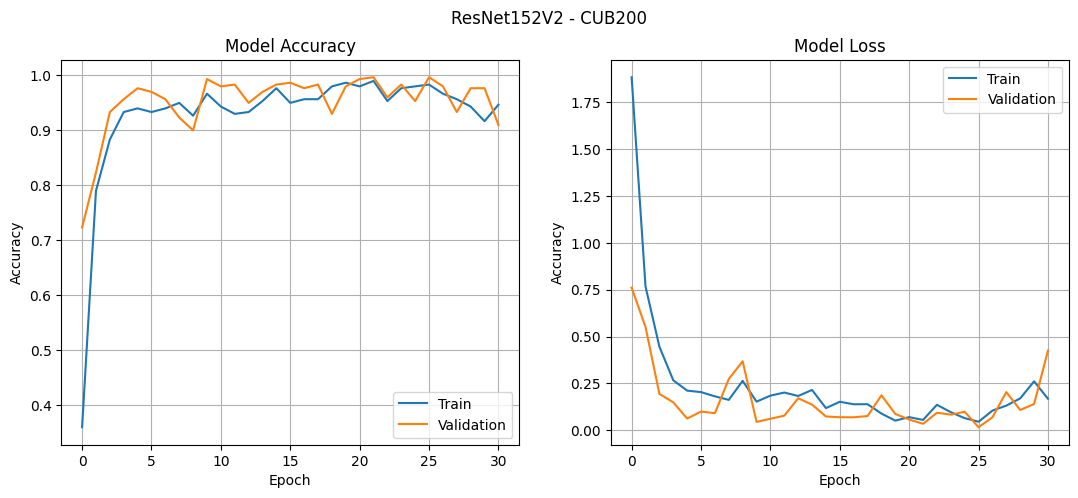

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet152V2 - CUB200')

##**A.4. InceptionV3**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_inceptionv3'

In [ ]:
base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

87910968/87910968 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn=compile_model(based_model=base_model, classes_num=class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-141-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8446 - accuracy: 0.3633
Epoch 1: loss improved from inf to 1.84462, saving model to TransferLearning/cub200_inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 66s 759ms/step - loss: 1.8446 - accuracy: 0.3633 - val_loss: 1.0106 - val_accuracy: 0.6533
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.8230 - accuracy: 0.7633
Epoch 2: loss improved from 1.84462 to 0.82299, saving model to TransferLearning/cub200_inceptionv3.h5
25/25 [==============================] - 19s 795ms/step - loss: 0.8230 - accuracy: 0.7633 - val_loss: 0.5953 - val_accuracy: 0.8167
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.3671 - accuracy: 0.8967
Epoch 3: loss improved from 0.82299 to 0.36709, saving model to TransferLearning/cub200_inceptionv3.h5
25/25 [==============================] - 19s 772ms/step - loss: 0.3671 - accuracy: 0.8967 - val_loss: 0.3493 - val_accuracy: 0.8700
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.8833
Epoch 4: loss improved from 0.36709 to 0.31105, saving model to TransferLearning/cub200_inceptionv3.h5
25/25 [======

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 23911210 (91.21 MB)
Trainable params: 23876778 (91.08 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 274ms/step - loss: 0.0244 - accuracy: 0.9933
Accuracy is 99.33333396911621%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 197ms/step - loss: 0.0334 - accuracy: 0.9900
Accuracy is 99.00000095367432%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 248ms/step - loss: 0.0149 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 238ms/step - loss: 0.0368 - accuracy: 0.9867
Accuracy is 98.66666793823242%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 210ms/step - loss: 0.0359 - accuracy: 0.9867
Accuracy is 98.66666793823242%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

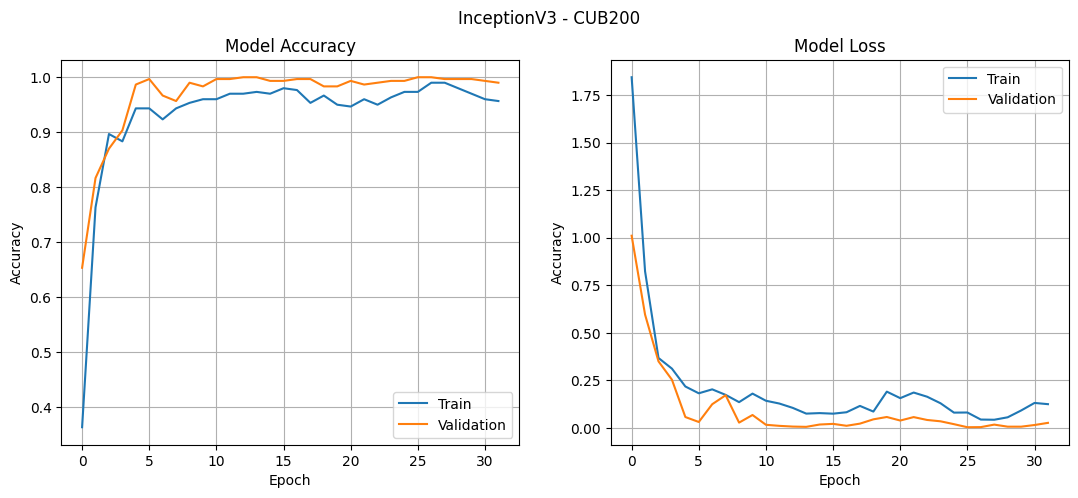

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='InceptionV3 - CUB200')

##**A.5. DenseNet121**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_densenet121'

In [ ]:
base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

29084464/29084464 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-20-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.9060 - accuracy: 0.3633
Epoch 1: loss improved from inf to 1.90603, saving model to TransferLearning/cub200_densenet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 182s 4s/step - loss: 1.9060 - accuracy: 0.3633 - val_loss: 0.7793 - val_accuracy: 0.8600
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.7980 - accuracy: 0.8000
Epoch 2: loss improved from 1.90603 to 0.79803, saving model to TransferLearning/cub200_densenet121.h5
25/25 [==============================] - 14s 556ms/step - loss: 0.7980 - accuracy: 0.8000 - val_loss: 0.3123 - val_accuracy: 0.9200
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.3903 - accuracy: 0.9300
Epoch 3: loss improved from 0.79803 to 0.39033, saving model to TransferLearning/cub200_densenet121.h5
25/25 [==============================] - 15s 608ms/step - loss: 0.3903 - accuracy: 0.9300 - val_loss: 0.1123 - val_accuracy: 0.9767
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9433
Epoch 4: loss improved from 0.39033 to 0.27094, saving model to TransferLearning/cub200_densenet121.h5
25/25 [========

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 206ms/step - loss: 0.0156 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 219ms/step - loss: 0.0057 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 205ms/step - loss: 0.0195 - accuracy: 0.9933
Accuracy is 99.33333396911621%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 261ms/step - loss: 0.0054 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 204ms/step - loss: 0.0134 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

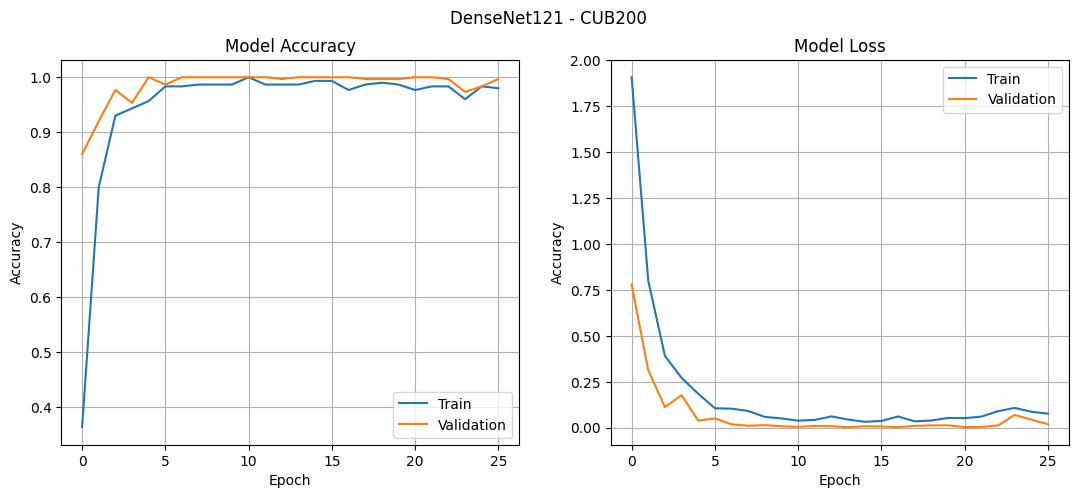

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title = 'DenseNet121 - CUB200')

##**A.6. DenseNet201**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_densenet201'

In [ ]:
base_model=DenseNet201(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

74836368/74836368 [==============================] - 4s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-32-90ead0958d0b>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.7458 - accuracy: 0.4200
Epoch 1: loss improved from inf to 1.74577, saving model to TransferLearning/cub200_densenet201.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 132s 1s/step - loss: 1.7458 - accuracy: 0.4200 - val_loss: 0.5718 - val_accuracy: 0.9067
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.5218 - accuracy: 0.9100
Epoch 2: loss improved from 1.74577 to 0.52180, saving model to TransferLearning/cub200_densenet201.h5
25/25 [==============================] - 22s 905ms/step - loss: 0.5218 - accuracy: 0.9100 - val_loss: 0.2141 - val_accuracy: 0.9433
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9467
Epoch 3: loss improved from 0.52180 to 0.23172, saving model to TransferLearning/cub200_densenet201.h5
25/25 [==============================] - 21s 858ms/step - loss: 0.2317 - accuracy: 0.9467 - val_loss: 0.0554 - val_accuracy: 0.9967
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9800
Epoch 4: loss improved from 0.23172 to 0.11563, saving model to TransferLearning/cub200_densenet201.h5
25/25 [========

* **Assessment**

In [ ]:
get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_4  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1024)              1967104   
                                                                 
 dense_9 (Dense)             (None, 10)                10250     
                                                                 
Total params: 20299338 (77.44 MB)
Trainable params: 20070282 (76.56 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 15s 244ms/step - loss: 0.0166 - accuracy: 0.9933
Accuracy is 99.33333396911621%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 213ms/step - loss: 0.0019 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 234ms/step - loss: 0.0066 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 266ms/step - loss: 0.0032 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 5s 212ms/step - loss: 0.0050 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

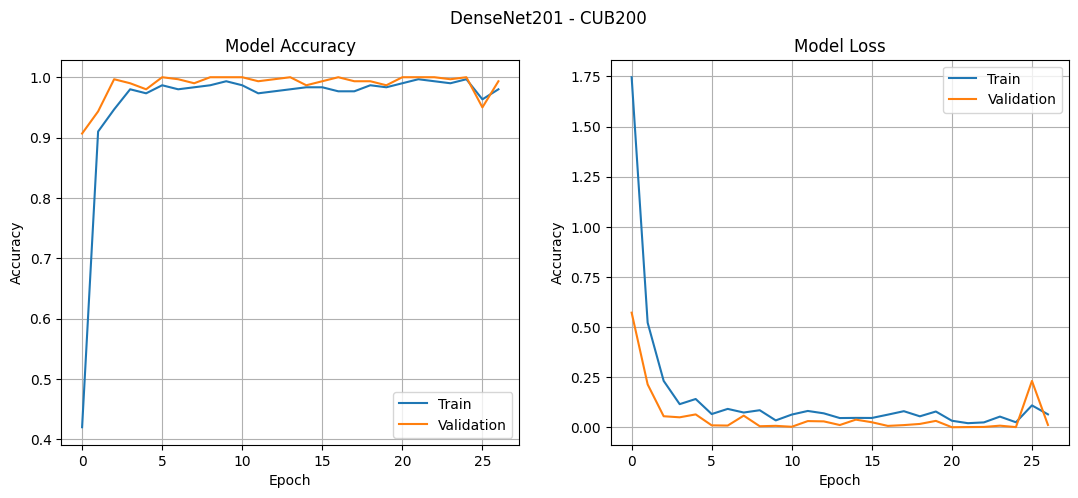

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='DenseNet201 - CUB200')

##**A.7. NASNetLarge**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_nasnetlarge'

In [ ]:
base_model=NASNetLarge(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-32-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.6998 - accuracy: 0.4767
Epoch 1: loss improved from inf to 1.69977, saving model to TransferLearning/cub200_nasnetlarge.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 251s 2s/step - loss: 1.6998 - accuracy: 0.4767 - val_loss: 0.7764 - val_accuracy: 0.7333
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.6211 - accuracy: 0.7833
Epoch 2: loss improved from 1.69977 to 0.62112, saving model to TransferLearning/cub200_nasnetlarge.h5
25/25 [==============================] - 98s 4s/step - loss: 0.6211 - accuracy: 0.7833 - val_loss: 0.5079 - val_accuracy: 0.8200
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.2864 - accuracy: 0.9033
Epoch 3: loss improved from 0.62112 to 0.28641, saving model to TransferLearning/cub200_nasnetlarge.h5
25/25 [==============================] - 98s 4s/step - loss: 0.2864 - accuracy: 0.9033 - val_loss: 0.3204 - val_accuracy: 0.8933
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9200
Epoch 4: loss improved from 0.28641 to 0.25317, saving model to TransferLearning/cub200_nasnetlarge.h5
25/25 [==============

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d_2  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              4129792   
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 89056860 (339.72 MB)
Trainable params: 88860192 (338.97 MB)
Non-trainable params: 196668 (768.23 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 256s 10s/step - loss: 0.0263 - accuracy: 0.9933
Accuracy is 99.33333396911621%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 8s 294ms/step - loss: 0.0092 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 284ms/step - loss: 0.0086 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 236ms/step - loss: 0.0351 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 8s 298ms/step - loss: 8.4826e-04 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

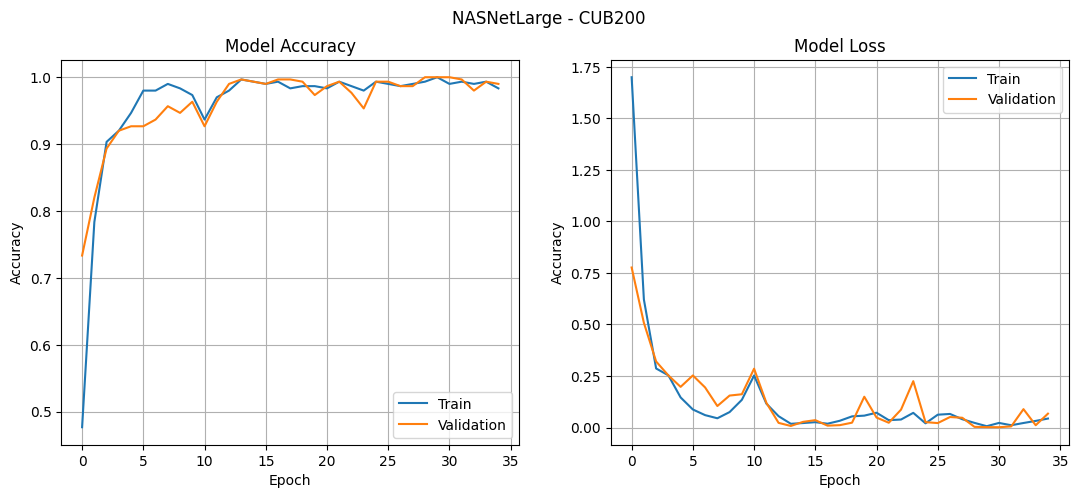

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='NASNetLarge - CUB200')

##**A.8. EfficientNetV2L**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


* **Model Setting**

In [ ]:
model_name='cub200_efficientnetv2l'

In [ ]:
base_model=EfficientNetV2L(include_top=False, weights='imagenet',input_shape=(images_size,images_size,3))

473176280/473176280 [==============================] - 25s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-38-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.9469 - accuracy: 0.3933
Epoch 1: loss improved from inf to 1.94694, saving model to TransferLearning/cub200_efficientnetv2l.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 328s 6s/step - loss: 1.9469 - accuracy: 0.3933 - val_loss: 1.0889 - val_accuracy: 0.7600
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.8429 - accuracy: 0.8167
Epoch 2: loss improved from 1.94694 to 0.84291, saving model to TransferLearning/cub200_efficientnetv2l.h5
25/25 [==============================] - 80s 3s/step - loss: 0.8429 - accuracy: 0.8167 - val_loss: 0.2909 - val_accuracy: 0.9600
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.9033
Epoch 3: loss improved from 0.84291 to 0.37483, saving model to TransferLearning/cub200_efficientnetv2l.h5
25/25 [==============================] - 92s 4s/step - loss: 0.3748 - accuracy: 0.9033 - val_loss: 0.1227 - val_accuracy: 0.9800
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.2348 - accuracy: 0.9467
Epoch 4: loss improved from 0.37483 to 0.23477, saving model to TransferLearning/cub200_efficientnetv2l.h5
25/25 [==

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 7, 7, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_7 (Dense)             (None, 10)                10250     
                                                                 
Total params: 119068842 (454.21 MB)
Trainable params: 118556266 (452.26 MB)
Non-trainable params: 512576 (1.96 MB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 300 images belonging to 10 classes.
25/25 [==============================] - 19s 225ms/step - loss: 0.0020 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 231ms/step - loss: 0.0065 - accuracy: 0.9967
Accuracy is 99.6666669845581%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 7s 281ms/step - loss: 0.0016 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 238ms/step - loss: 0.0016 - accuracy: 1.0000
Accuracy is 100.0%
Found 300 images belonging to 10 classes.
25/25 [==============================] - 6s 239ms/step - loss: 0.0015 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

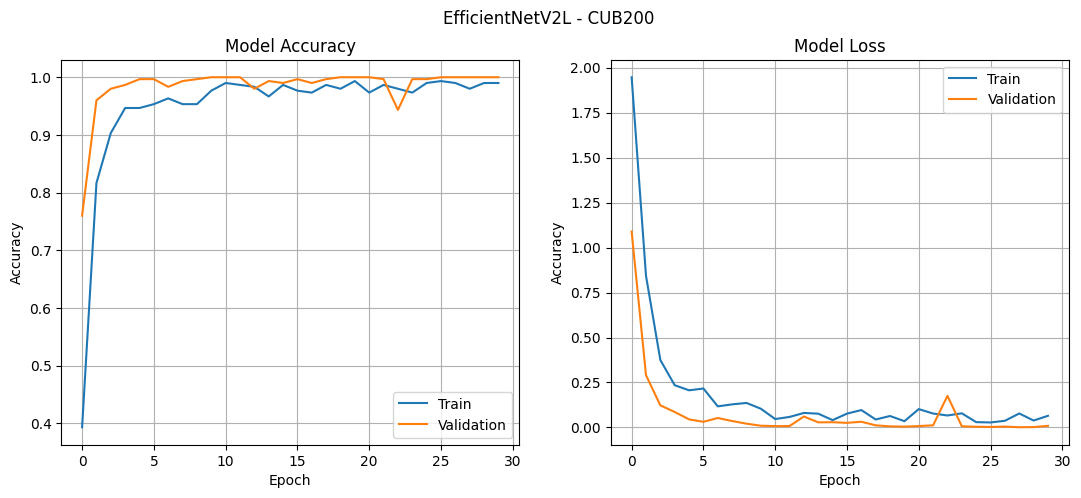

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='EfficientNetV2L - CUB200')

##**A.F. Model Comparison**

In [ ]:
models=['xception','resnet50','resnet152v2','inceptionv3','densenet121','densenet201','nasnetlarge','efficientnetv2l']
hists=[]
for m in models:
    hists.append(get_hist(model_name=f'{data_name}_{m}'))
colors=['red','green','blue','yellow','purple','orange','pink','cyan']

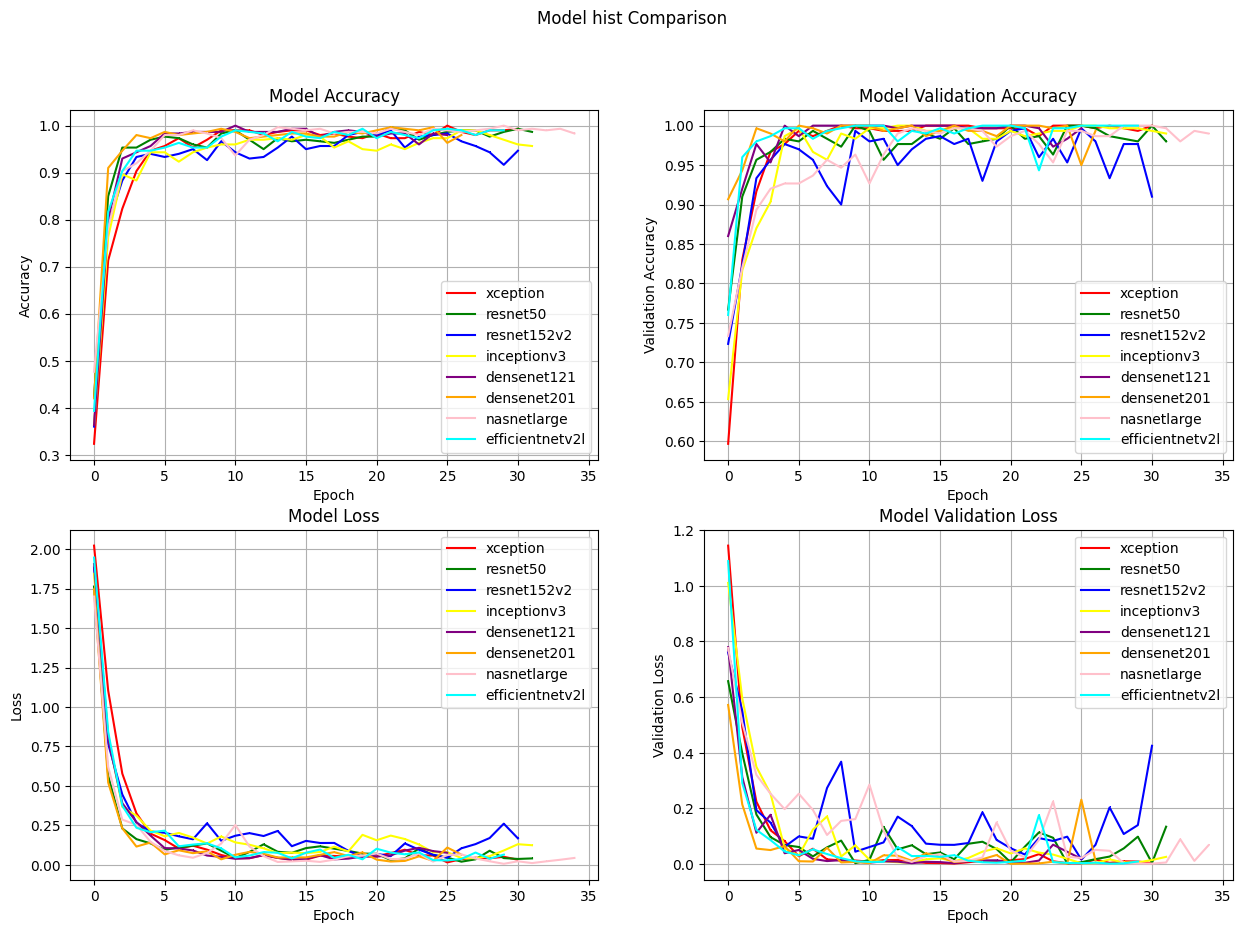

In [ ]:
show_model_comparison(hist_list=hists, color_list=colors, model_list=models, data_name=data_name)

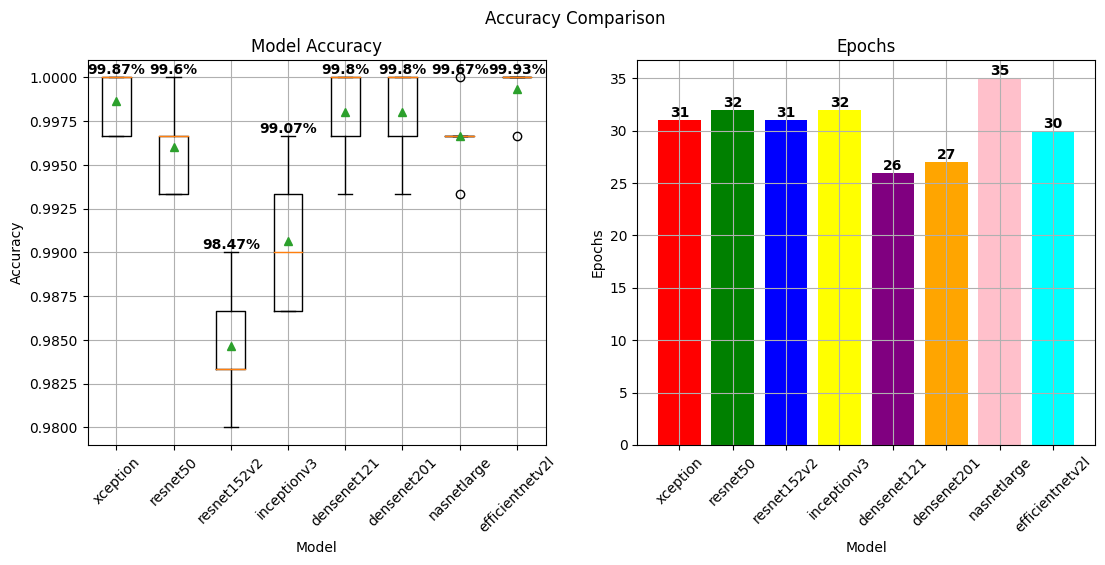

In [ ]:
show_accuracy_comparison(data_name=data_name, model_list=models, color_list=colors, hist_list=hists)

#**B. ani**

In [ ]:
train_dir = 'ani/train'
val_dir = 'ani/val'
data_name='ani'

In [ ]:
images_size=224
class_number=7

##**B.1. Xception**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

* **Model Setting**

In [ ]:
model_name='ani_xception'

In [ ]:
base_model=Xception(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

83683744/83683744 [==============================] - 1s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-24-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8399 - accuracy: 0.2872
Epoch 1: loss improved from inf to 1.83986, saving model to TransferLearning/ani_xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 148s 5s/step - loss: 1.8399 - accuracy: 0.2872 - val_loss: 1.9907 - val_accuracy: 0.2703
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.5661 - accuracy: 0.4426
Epoch 2: loss improved from 1.83986 to 1.56613, saving model to TransferLearning/ani_xception.h5
25/25 [==============================] - 12s 498ms/step - loss: 1.5661 - accuracy: 0.4426 - val_loss: 1.7748 - val_accuracy: 0.3615
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.5405
Epoch 3: loss improved from 1.56613 to 1.27655, saving model to TransferLearning/ani_xception.h5
25/25 [==============================] - 13s 515ms/step - loss: 1.2765 - accuracy: 0.5405 - val_loss: 1.3278 - val_accuracy: 0.5405
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.0244 - accuracy: 0.6655
Epoch 4: loss improved from 1.27655 to 1.02440, saving model to TransferLearning/ani_xception.h5
25/25 [==========================

* **Assessment**

In [ ]:
#get_cnn(model_name, new_cnn=cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 22966831 (87.61 MB)
Trainable params: 22912303 (87.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 210ms/step - loss: 0.0250 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 198ms/step - loss: 0.0259 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 231ms/step - loss: 0.0184 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 228ms/step - loss: 0.0159 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 195ms/step - loss: 0.0336 - accuracy: 0.9831
Accuracy is 98.31081032752991%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

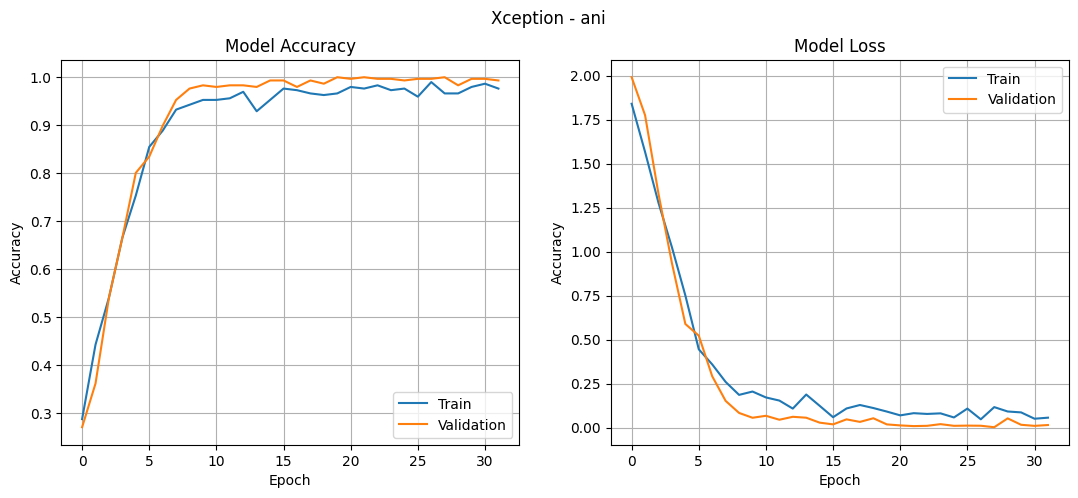

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='Xception - ani',)

##**B.2. ResNet50**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_resnet50'

In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

94765736/94765736 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-39-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8125 - accuracy: 0.3277
Epoch 1: loss improved from inf to 1.81248, saving model to TransferLearning/ani_resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 58s 924ms/step - loss: 1.8125 - accuracy: 0.3277 - val_loss: 1.6672 - val_accuracy: 0.4257
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.9781 - accuracy: 0.6622
Epoch 2: loss improved from 1.81248 to 0.97806, saving model to TransferLearning/ani_resnet50.h5
25/25 [==============================] - 20s 802ms/step - loss: 0.9781 - accuracy: 0.6622 - val_loss: 1.0222 - val_accuracy: 0.6892
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7872
Epoch 3: loss improved from 0.97806 to 0.64993, saving model to TransferLearning/ani_resnet50.h5
25/25 [==============================] - 15s 610ms/step - loss: 0.6499 - accuracy: 0.7872 - val_loss: 0.8251 - val_accuracy: 0.7872
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8446
Epoch 4: loss improved from 0.64993 to 0.48182, saving model to TransferLearning/ani_resnet50.h5
25/25 [========================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 25693063 (98.01 MB)
Trainable params: 25639943 (97.81 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 192ms/step - loss: 0.0502 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 242ms/step - loss: 0.0234 - accuracy: 1.0000
Accuracy is 100.0%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 191ms/step - loss: 0.0402 - accuracy: 0.9865
Accuracy is 98.64864945411682%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 232ms/step - loss: 0.0507 - accuracy: 0.9865
Accuracy is 98.64864945411682%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 194ms/step - loss: 0.0217 - accuracy: 0.9966
Accuracy is 99.66216087341309%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

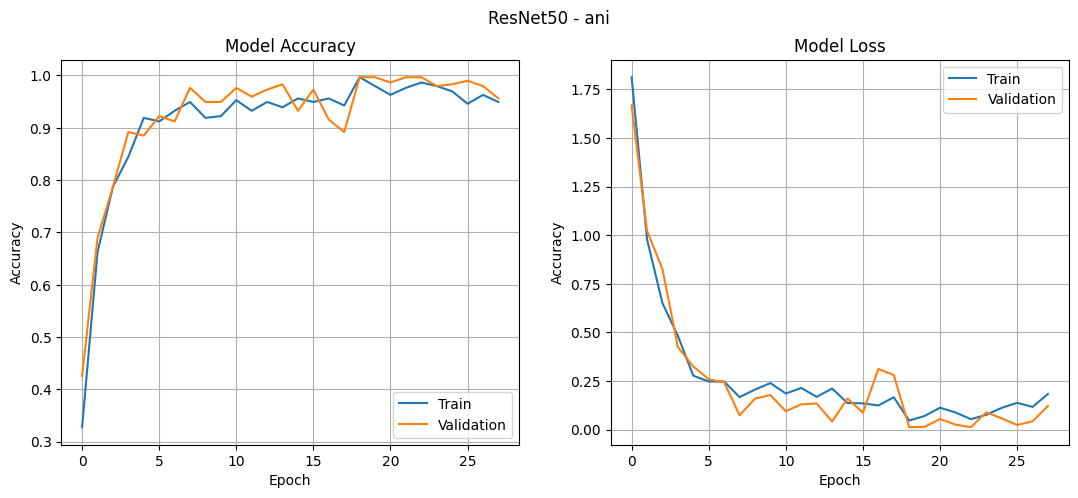

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet50 - ani')

##**B.3. ResNet152V2**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_resnet152v2'

In [ ]:
base_model=ResNet152V2(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

234545216/234545216 [==============================] - 1s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-52-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.7583 - accuracy: 0.3378
Epoch 1: loss improved from inf to 1.75830, saving model to TransferLearning/ani_resnet152v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 119s 1s/step - loss: 1.7583 - accuracy: 0.3378 - val_loss: 1.8809 - val_accuracy: 0.4088
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.2330 - accuracy: 0.5574
Epoch 2: loss improved from 1.75830 to 1.23305, saving model to TransferLearning/ani_resnet152v2.h5
25/25 [==============================] - 40s 2s/step - loss: 1.2330 - accuracy: 0.5574 - val_loss: 1.1591 - val_accuracy: 0.6216
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8418 - accuracy: 0.6993
Epoch 3: loss improved from 1.23305 to 0.84184, saving model to TransferLearning/ani_resnet152v2.h5
25/25 [==============================] - 43s 2s/step - loss: 0.8418 - accuracy: 0.6993 - val_loss: 0.7684 - val_accuracy: 0.7466
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8209
Epoch 4: loss improved from 0.84184 to 0.53813, saving model to TransferLearning/ani_resnet152v2.h5
25/25 [=======================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 60436999 (230.55 MB)
Trainable params: 60293255 (230.00 MB)
Non-trainable params: 143744 (561.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 7s 257ms/step - loss: 0.1267 - accuracy: 0.9561
Accuracy is 95.60810923576355%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 252ms/step - loss: 0.1080 - accuracy: 0.9730
Accuracy is 97.29729890823364%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 207ms/step - loss: 0.0725 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 8s 302ms/step - loss: 0.1384 - accuracy: 0.9561
Accuracy is 95.60810923576355%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 212ms/step - loss: 0.1397 - accuracy: 0.9595
Accuracy is 95.94594836235046%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

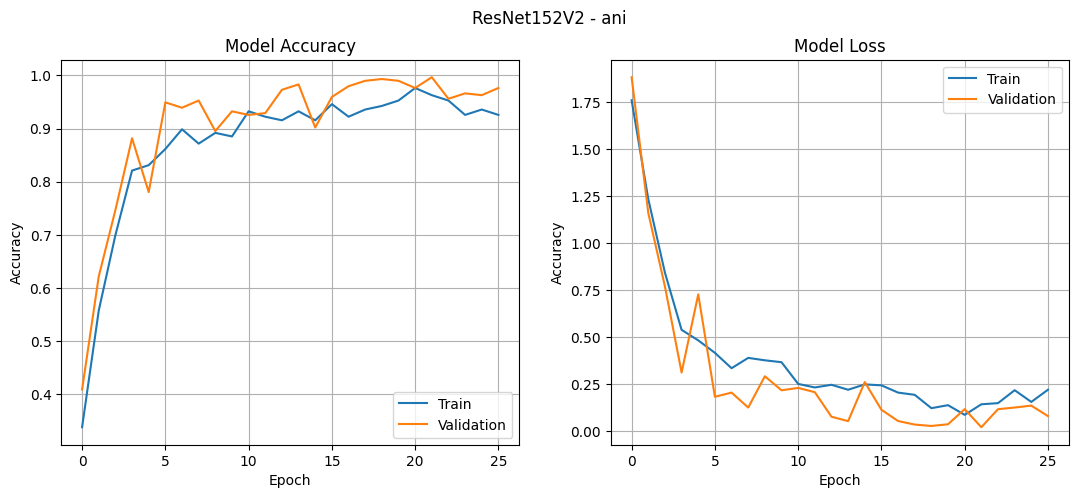

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet152V2 - ani')

##**B.4. InceptionV3**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_inceptionv3'

In [ ]:
base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

87910968/87910968 [==============================] - 4s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn=compile_model(based_model=base_model, classes_num=class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-24-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8621 - accuracy: 0.3007
Epoch 1: loss improved from inf to 1.86211, saving model to TransferLearning/ani_inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 209s 7s/step - loss: 1.8621 - accuracy: 0.3007 - val_loss: 1.8337 - val_accuracy: 0.3277
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.5227 - accuracy: 0.4358
Epoch 2: loss improved from 1.86211 to 1.52273, saving model to TransferLearning/ani_inceptionv3.h5
25/25 [==============================] - 13s 534ms/step - loss: 1.5227 - accuracy: 0.4358 - val_loss: 1.4033 - val_accuracy: 0.5034
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.6149
Epoch 3: loss improved from 1.52273 to 1.15868, saving model to TransferLearning/ani_inceptionv3.h5
25/25 [==============================] - 14s 553ms/step - loss: 1.1587 - accuracy: 0.6149 - val_loss: 1.2748 - val_accuracy: 0.5709
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.6757
Epoch 4: loss improved from 1.15868 to 0.88514, saving model to TransferLearning/ani_inceptionv3.h5
25/25 [=================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 23908135 (91.20 MB)
Trainable params: 23873703 (91.07 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 183ms/step - loss: 0.0300 - accuracy: 0.9899
Accuracy is 98.98648858070374%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 235ms/step - loss: 0.0436 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 185ms/step - loss: 0.0715 - accuracy: 0.9797
Accuracy is 97.972971200943%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 188ms/step - loss: 0.0962 - accuracy: 0.9662
Accuracy is 96.62162065505981%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 229ms/step - loss: 0.1096 - accuracy: 0.9764
Accuracy is 97.63513803482056%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

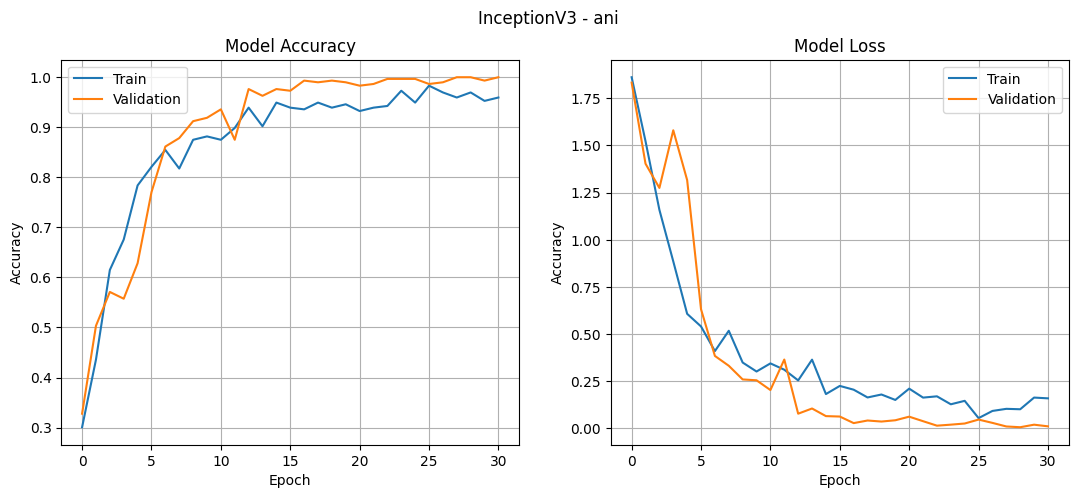

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='InceptionV3 - ani')

##**B.5. DenseNet121**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_densenet121'

In [ ]:
base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

29084464/29084464 [==============================] - 2s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-33-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8729 - accuracy: 0.2973
Epoch 1: loss improved from inf to 1.87289, saving model to TransferLearning/ani_densenet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 101s 1s/step - loss: 1.8729 - accuracy: 0.2973 - val_loss: 1.6140 - val_accuracy: 0.3919
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.2845 - accuracy: 0.5541
Epoch 2: loss improved from 1.87289 to 1.28448, saving model to TransferLearning/ani_densenet121.h5
25/25 [==============================] - 13s 524ms/step - loss: 1.2845 - accuracy: 0.5541 - val_loss: 1.1675 - val_accuracy: 0.6014
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.7432
Epoch 3: loss improved from 1.28448 to 0.87382, saving model to TransferLearning/ani_densenet121.h5
25/25 [==============================] - 15s 616ms/step - loss: 0.8738 - accuracy: 0.7432 - val_loss: 0.8549 - val_accuracy: 0.6993
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.7939
Epoch 4: loss improved from 0.87382 to 0.62367, saving model to TransferLearning/ani_densenet121.h5
25/25 [=================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 187ms/step - loss: 0.0409 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 237ms/step - loss: 0.0464 - accuracy: 0.9865
Accuracy is 98.64864945411682%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 224ms/step - loss: 0.0696 - accuracy: 0.9797
Accuracy is 97.972971200943%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 192ms/step - loss: 0.0403 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 247ms/step - loss: 0.0417 - accuracy: 0.9797
Accuracy is 97.972971200943%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

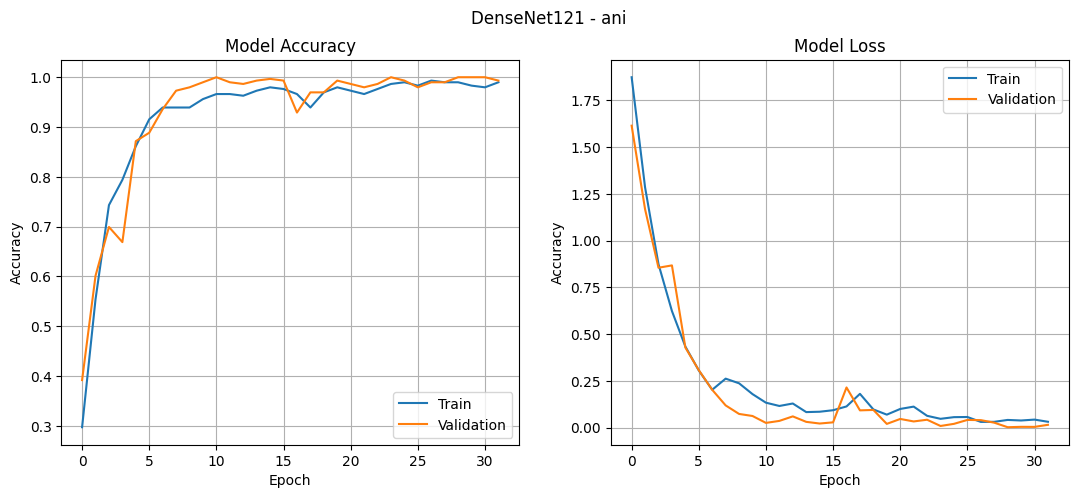

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title = 'DenseNet121 - ani')

##**B.6. DenseNet201**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_densenet201'

In [ ]:
base_model=DenseNet201(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-41-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8520 - accuracy: 0.3007
Epoch 1: loss improved from inf to 1.85200, saving model to TransferLearning/ani_densenet201.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 136s 1s/step - loss: 1.8520 - accuracy: 0.3007 - val_loss: 1.8132 - val_accuracy: 0.3885
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.6351
Epoch 2: loss improved from 1.85200 to 1.08500, saving model to TransferLearning/ani_densenet201.h5
25/25 [==============================] - 24s 1s/step - loss: 1.0850 - accuracy: 0.6351 - val_loss: 1.2821 - val_accuracy: 0.5203
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.7736
Epoch 3: loss improved from 1.08500 to 0.67384, saving model to TransferLearning/ani_densenet201.h5
25/25 [==============================] - 30s 1s/step - loss: 0.6738 - accuracy: 0.7736 - val_loss: 1.1894 - val_accuracy: 0.5980
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8953
Epoch 4: loss improved from 0.67384 to 0.37605, saving model to TransferLearning/ani_densenet201.h5
25/25 [=======================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_5  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1024)              1967104   
                                                                 
 dense_11 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 20296263 (77.42 MB)
Trainable params: 20067207 (76.55 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 201s 8s/step - loss: 0.0351 - accuracy: 0.9899
Accuracy is 98.98648858070374%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 226ms/step - loss: 0.0166 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 254ms/step - loss: 0.0510 - accuracy: 0.9764
Accuracy is 97.63513803482056%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 200ms/step - loss: 0.0259 - accuracy: 0.9932
Accuracy is 99.32432174682617%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 235ms/step - loss: 0.0655 - accuracy: 0.9797
Accuracy is 97.972971200943%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

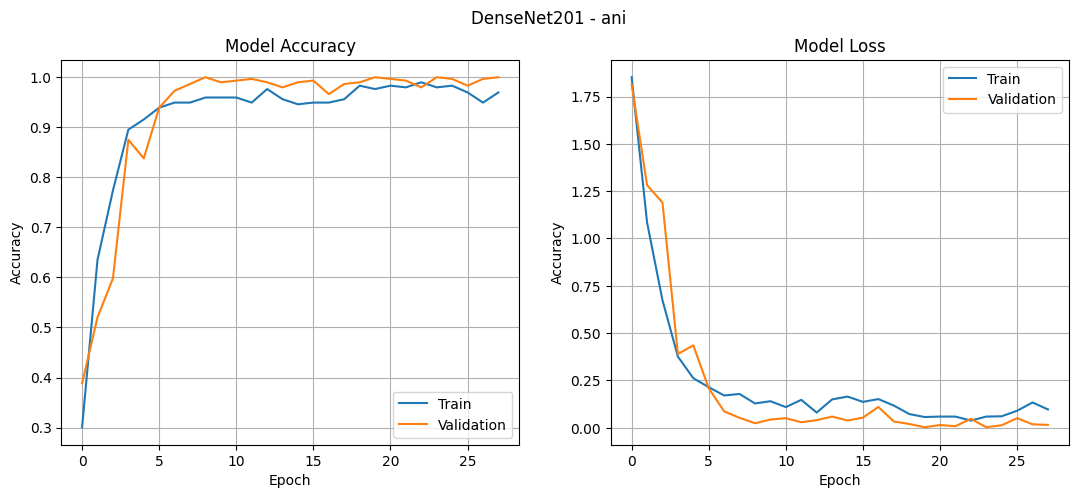

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='DenseNet201 - ani')

##**B.7. NASNetLarge**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_nasnetlarge'

In [ ]:
base_model=NASNetLarge(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-32-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8105 - accuracy: 0.3311
Epoch 1: loss improved from inf to 1.81047, saving model to TransferLearning/ani_nasnetlarge.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 278s 4s/step - loss: 1.8105 - accuracy: 0.3311 - val_loss: 1.6710 - val_accuracy: 0.3547
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.3244 - accuracy: 0.5034
Epoch 2: loss improved from 1.81047 to 1.32442, saving model to TransferLearning/ani_nasnetlarge.h5
25/25 [==============================] - 114s 5s/step - loss: 1.3244 - accuracy: 0.5034 - val_loss: 1.5322 - val_accuracy: 0.4662
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.7061
Epoch 3: loss improved from 1.32442 to 0.95657, saving model to TransferLearning/ani_nasnetlarge.h5
25/25 [==============================] - 158s 7s/step - loss: 0.9566 - accuracy: 0.7061 - val_loss: 1.4741 - val_accuracy: 0.5270
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.8243
Epoch 4: loss improved from 0.95657 to 0.55753, saving model to TransferLearning/ani_nasnetlarge.h5
25/25 [=====================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d_6  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1024)              4129792   
                                                                 
 dense_13 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 89053785 (339.71 MB)
Trainable params: 88857117 (338.96 MB)
Non-trainable params: 196668 (768.23 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 16s 282ms/step - loss: 0.2641 - accuracy: 0.9155
Accuracy is 91.55405163764954%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 239ms/step - loss: 0.2100 - accuracy: 0.9324
Accuracy is 93.24324131011963%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 7s 269ms/step - loss: 0.1904 - accuracy: 0.9324
Accuracy is 93.24324131011963%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 222ms/step - loss: 0.2328 - accuracy: 0.9223
Accuracy is 92.22972989082336%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 7s 269ms/step - loss: 0.1776 - accuracy: 0.9426
Accuracy is 94.25675868988037%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

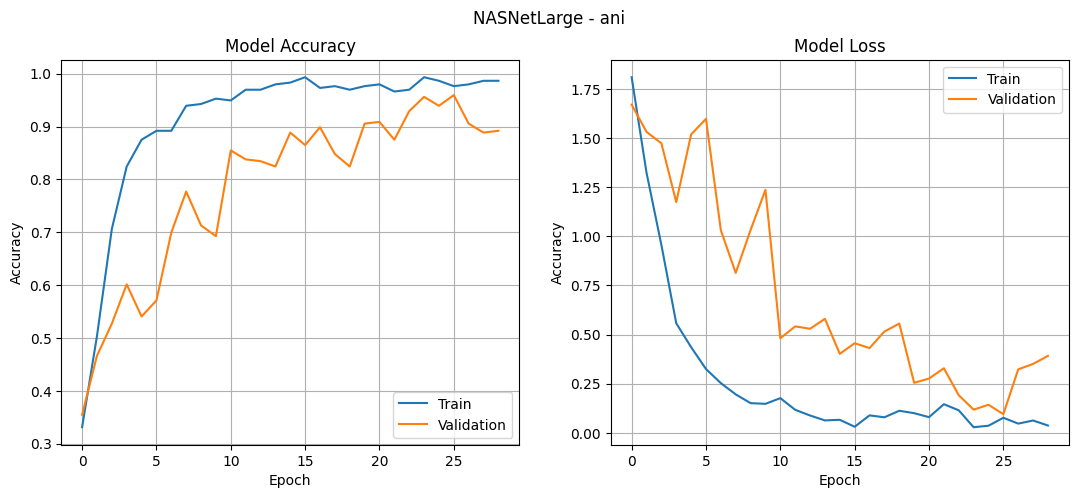

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='NASNetLarge - ani')

##**B.8. EfficientNetV2L**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_efficientnetv2l'

In [ ]:
base_model=EfficientNetV2L(include_top=False, weights='imagenet',input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-25-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8474 - accuracy: 0.2872
Epoch 1: loss improved from inf to 1.84738, saving model to TransferLearning/ani_efficientnetv2l.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 346s 6s/step - loss: 1.8474 - accuracy: 0.2872 - val_loss: 1.5002 - val_accuracy: 0.5068
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.3634 - accuracy: 0.5473
Epoch 2: loss improved from 1.84738 to 1.36337, saving model to TransferLearning/ani_efficientnetv2l.h5
25/25 [==============================] - 97s 4s/step - loss: 1.3634 - accuracy: 0.5473 - val_loss: 0.9811 - val_accuracy: 0.7297
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8839 - accuracy: 0.7568
Epoch 3: loss improved from 1.36337 to 0.88386, saving model to TransferLearning/ani_efficientnetv2l.h5
25/25 [==============================] - 96s 4s/step - loss: 0.8839 - accuracy: 0.7568 - val_loss: 0.4194 - val_accuracy: 0.9426
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.8378
Epoch 4: loss improved from 0.88386 to 0.54858, saving model to TransferLearning/ani_efficientnetv2l.h5
25/25 [===========

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 7, 7, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_15 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 119065767 (454.20 MB)
Trainable params: 118553191 (452.24 MB)
Non-trainable params: 512576 (1.96 MB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 21s 289ms/step - loss: 0.0107 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 219ms/step - loss: 0.0202 - accuracy: 0.9932
Accuracy is 99.32432174682617%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 246ms/step - loss: 0.0203 - accuracy: 0.9899
Accuracy is 98.98648858070374%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 221ms/step - loss: 0.0247 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 220ms/step - loss: 0.0044 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

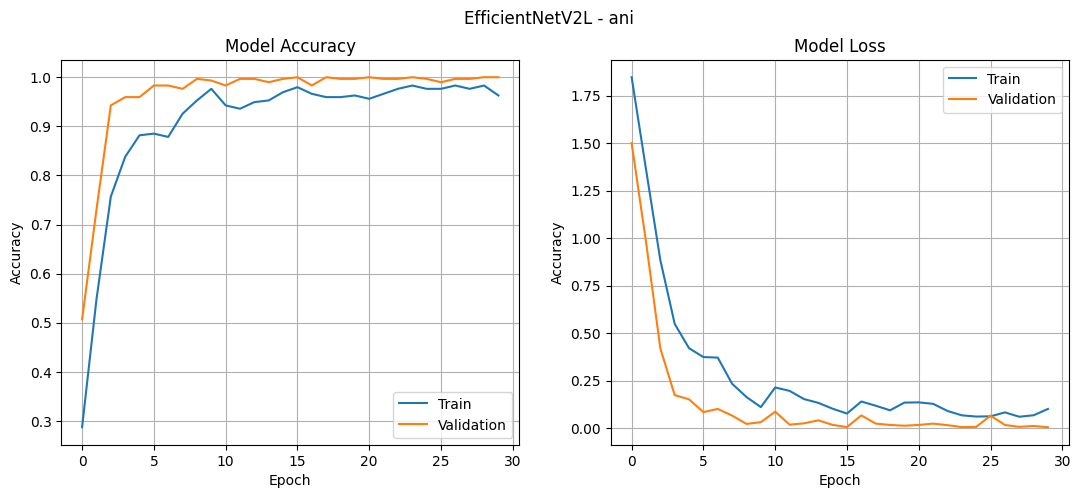

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='EfficientNetV2L - ani')

##**B.F. Model Comparison**

In [ ]:
hists=[]
for m in models:
    hists.append(get_hist(model_name=f'{data_name}_{m}'))

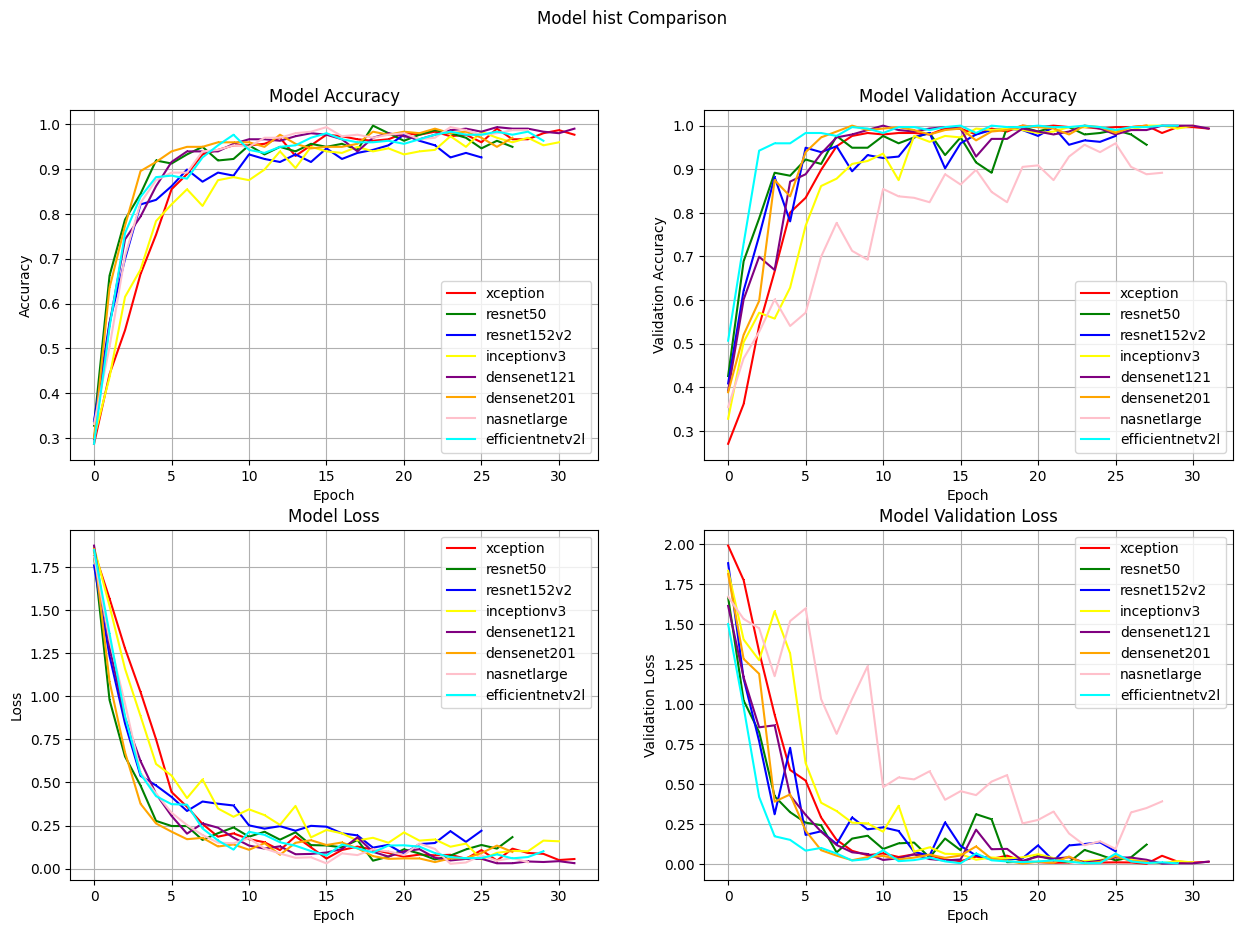

In [ ]:
show_model_comparison(hist_list=hists, color_list=colors, model_list=models, data_name=data_name)

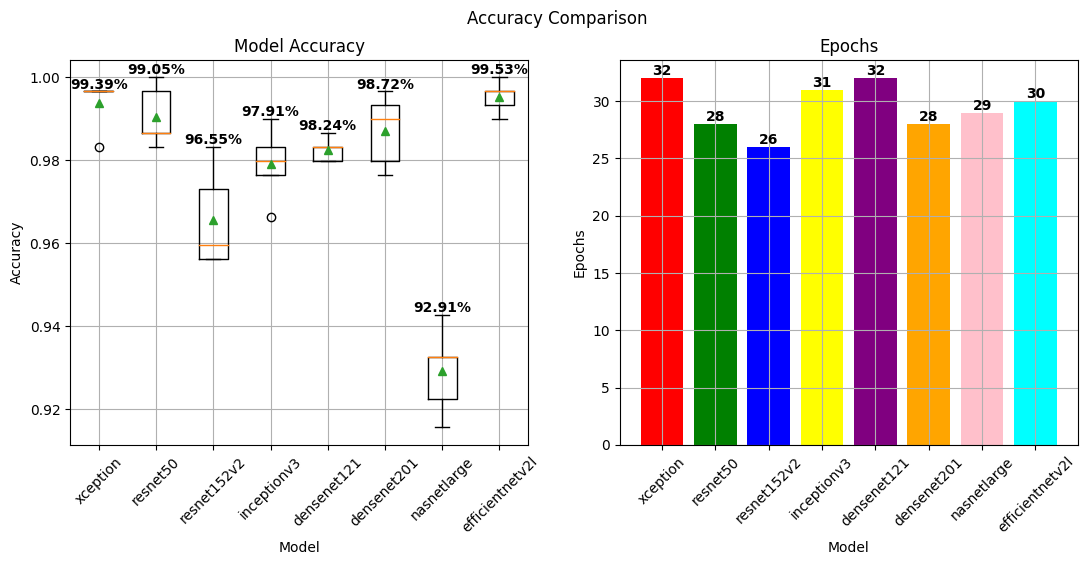

In [ ]:
show_accuracy_comparison(data_name=data_name, model_list=models, color_list=colors, hist_list=hists)

#**B-1. ani - Using Flatten() instead of GlobalAveragePooling2D()**

In [ ]:
train_dir = 'ani/train'
val_dir = 'ani/val'
data_name='ani'

In [ ]:
images_size=224
class_number=7

In [ ]:
def compile_model(based_model, classes_num):
    cnn = Sequential()
    cnn.add(based_model)
    cnn.add(Flatten())
    cnn.add(Dense(1024, activation = 'relu'))
    cnn.add(Dense(classes_num, activation = 'softmax'))

    cnn.compile(loss=ls, optimizer = Adam(0.0001), metrics = ['accuracy'])

    return cnn

##**B-1.1. Xception**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

* **Model Setting**

In [ ]:
model_name='ani_xception'

In [ ]:
base_model=Xception(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

83683744/83683744 [==============================] - 1s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-24-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8399 - accuracy: 0.2872
Epoch 1: loss improved from inf to 1.83986, saving model to TransferLearning/ani_xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 148s 5s/step - loss: 1.8399 - accuracy: 0.2872 - val_loss: 1.9907 - val_accuracy: 0.2703
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.5661 - accuracy: 0.4426
Epoch 2: loss improved from 1.83986 to 1.56613, saving model to TransferLearning/ani_xception.h5
25/25 [==============================] - 12s 498ms/step - loss: 1.5661 - accuracy: 0.4426 - val_loss: 1.7748 - val_accuracy: 0.3615
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.2765 - accuracy: 0.5405
Epoch 3: loss improved from 1.56613 to 1.27655, saving model to TransferLearning/ani_xception.h5
25/25 [==============================] - 13s 515ms/step - loss: 1.2765 - accuracy: 0.5405 - val_loss: 1.3278 - val_accuracy: 0.5405
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 1.0244 - accuracy: 0.6655
Epoch 4: loss improved from 1.27655 to 1.02440, saving model to TransferLearning/ani_xception.h5
25/25 [==========================

* **Assessment**

In [ ]:
#get_cnn(model_name, new_cnn=cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 22966831 (87.61 MB)
Trainable params: 22912303 (87.40 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 210ms/step - loss: 0.0250 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 198ms/step - loss: 0.0259 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 231ms/step - loss: 0.0184 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 228ms/step - loss: 0.0159 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 195ms/step - loss: 0.0336 - accuracy: 0.9831
Accuracy is 98.31081032752991%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

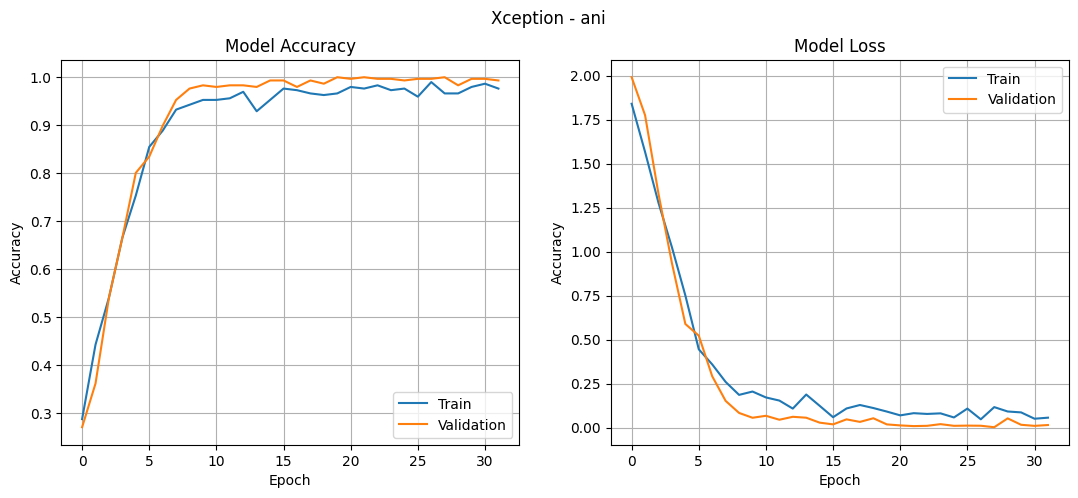

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='Xception - ani',)

##**B-1.2. ResNet50**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_resnet50'

In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

94765736/94765736 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-39-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8125 - accuracy: 0.3277
Epoch 1: loss improved from inf to 1.81248, saving model to TransferLearning/ani_resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 58s 924ms/step - loss: 1.8125 - accuracy: 0.3277 - val_loss: 1.6672 - val_accuracy: 0.4257
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.9781 - accuracy: 0.6622
Epoch 2: loss improved from 1.81248 to 0.97806, saving model to TransferLearning/ani_resnet50.h5
25/25 [==============================] - 20s 802ms/step - loss: 0.9781 - accuracy: 0.6622 - val_loss: 1.0222 - val_accuracy: 0.6892
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.7872
Epoch 3: loss improved from 0.97806 to 0.64993, saving model to TransferLearning/ani_resnet50.h5
25/25 [==============================] - 15s 610ms/step - loss: 0.6499 - accuracy: 0.7872 - val_loss: 0.8251 - val_accuracy: 0.7872
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8446
Epoch 4: loss improved from 0.64993 to 0.48182, saving model to TransferLearning/ani_resnet50.h5
25/25 [========================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 25693063 (98.01 MB)
Trainable params: 25639943 (97.81 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 192ms/step - loss: 0.0502 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 242ms/step - loss: 0.0234 - accuracy: 1.0000
Accuracy is 100.0%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 191ms/step - loss: 0.0402 - accuracy: 0.9865
Accuracy is 98.64864945411682%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 232ms/step - loss: 0.0507 - accuracy: 0.9865
Accuracy is 98.64864945411682%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 194ms/step - loss: 0.0217 - accuracy: 0.9966
Accuracy is 99.66216087341309%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

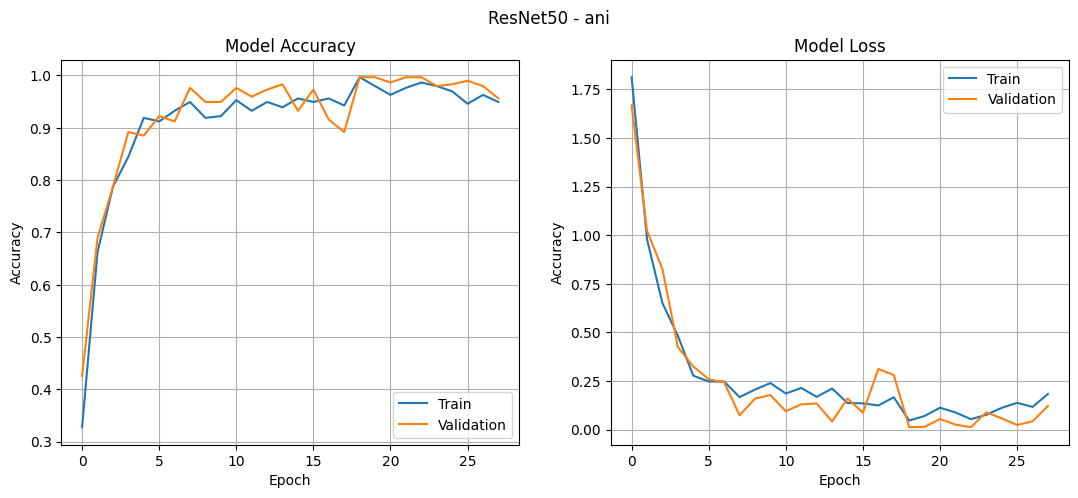

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet50 - ani')

##**B-1.3. ResNet152V2**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_resnet152v2'

In [ ]:
base_model=ResNet152V2(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

234545216/234545216 [==============================] - 1s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-52-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.7583 - accuracy: 0.3378
Epoch 1: loss improved from inf to 1.75830, saving model to TransferLearning/ani_resnet152v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 119s 1s/step - loss: 1.7583 - accuracy: 0.3378 - val_loss: 1.8809 - val_accuracy: 0.4088
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.2330 - accuracy: 0.5574
Epoch 2: loss improved from 1.75830 to 1.23305, saving model to TransferLearning/ani_resnet152v2.h5
25/25 [==============================] - 40s 2s/step - loss: 1.2330 - accuracy: 0.5574 - val_loss: 1.1591 - val_accuracy: 0.6216
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8418 - accuracy: 0.6993
Epoch 3: loss improved from 1.23305 to 0.84184, saving model to TransferLearning/ani_resnet152v2.h5
25/25 [==============================] - 43s 2s/step - loss: 0.8418 - accuracy: 0.6993 - val_loss: 0.7684 - val_accuracy: 0.7466
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5381 - accuracy: 0.8209
Epoch 4: loss improved from 0.84184 to 0.53813, saving model to TransferLearning/ani_resnet152v2.h5
25/25 [=======================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_5 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 60436999 (230.55 MB)
Trainable params: 60293255 (230.00 MB)
Non-trainable params: 143744 (561.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 7s 257ms/step - loss: 0.1267 - accuracy: 0.9561
Accuracy is 95.60810923576355%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 252ms/step - loss: 0.1080 - accuracy: 0.9730
Accuracy is 97.29729890823364%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 207ms/step - loss: 0.0725 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 8s 302ms/step - loss: 0.1384 - accuracy: 0.9561
Accuracy is 95.60810923576355%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 212ms/step - loss: 0.1397 - accuracy: 0.9595
Accuracy is 95.94594836235046%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

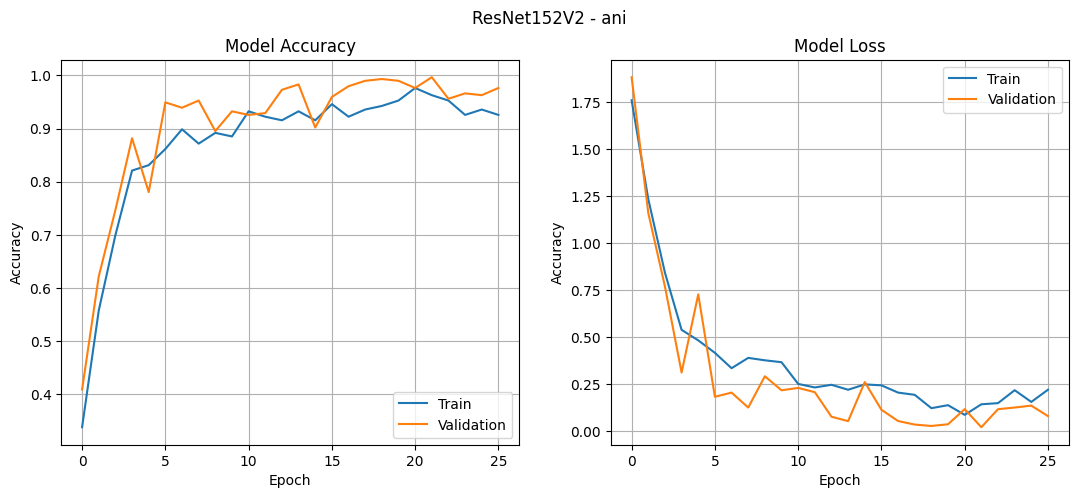

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet152V2 - ani')

##**B-1.4. InceptionV3**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_inceptionv3'

In [ ]:
base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

87910968/87910968 [==============================] - 4s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn=compile_model(based_model=base_model, classes_num=class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-24-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8621 - accuracy: 0.3007
Epoch 1: loss improved from inf to 1.86211, saving model to TransferLearning/ani_inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 209s 7s/step - loss: 1.8621 - accuracy: 0.3007 - val_loss: 1.8337 - val_accuracy: 0.3277
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.5227 - accuracy: 0.4358
Epoch 2: loss improved from 1.86211 to 1.52273, saving model to TransferLearning/ani_inceptionv3.h5
25/25 [==============================] - 13s 534ms/step - loss: 1.5227 - accuracy: 0.4358 - val_loss: 1.4033 - val_accuracy: 0.5034
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.1587 - accuracy: 0.6149
Epoch 3: loss improved from 1.52273 to 1.15868, saving model to TransferLearning/ani_inceptionv3.h5
25/25 [==============================] - 14s 553ms/step - loss: 1.1587 - accuracy: 0.6149 - val_loss: 1.2748 - val_accuracy: 0.5709
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.8851 - accuracy: 0.6757
Epoch 4: loss improved from 1.15868 to 0.88514, saving model to TransferLearning/ani_inceptionv3.h5
25/25 [=================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 23908135 (91.20 MB)
Trainable params: 23873703 (91.07 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 183ms/step - loss: 0.0300 - accuracy: 0.9899
Accuracy is 98.98648858070374%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 235ms/step - loss: 0.0436 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 185ms/step - loss: 0.0715 - accuracy: 0.9797
Accuracy is 97.972971200943%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 188ms/step - loss: 0.0962 - accuracy: 0.9662
Accuracy is 96.62162065505981%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 229ms/step - loss: 0.1096 - accuracy: 0.9764
Accuracy is 97.63513803482056%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

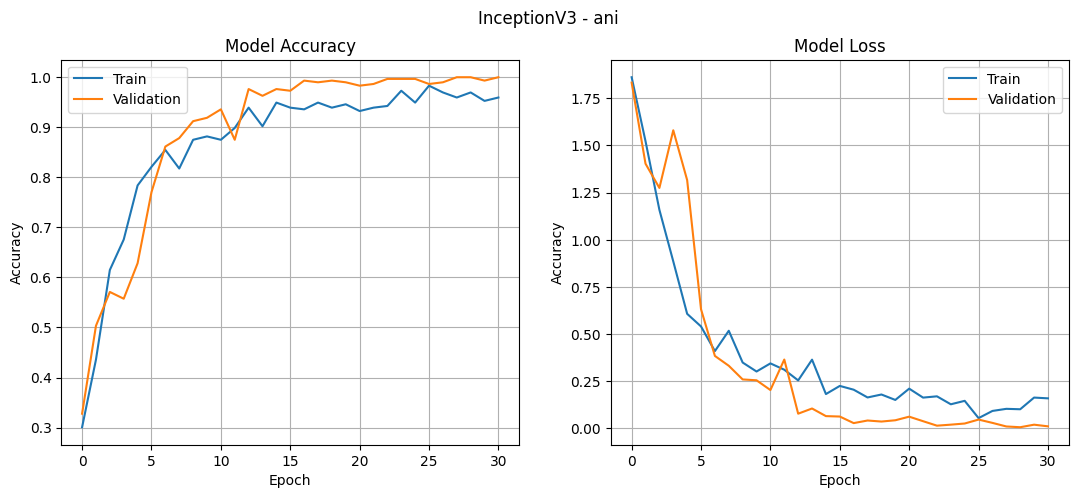

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='InceptionV3 - ani')

##**B-1.5. DenseNet121**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_densenet121'

In [ ]:
base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

29084464/29084464 [==============================] - 2s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-33-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8729 - accuracy: 0.2973
Epoch 1: loss improved from inf to 1.87289, saving model to TransferLearning/ani_densenet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 101s 1s/step - loss: 1.8729 - accuracy: 0.2973 - val_loss: 1.6140 - val_accuracy: 0.3919
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.2845 - accuracy: 0.5541
Epoch 2: loss improved from 1.87289 to 1.28448, saving model to TransferLearning/ani_densenet121.h5
25/25 [==============================] - 13s 524ms/step - loss: 1.2845 - accuracy: 0.5541 - val_loss: 1.1675 - val_accuracy: 0.6014
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.7432
Epoch 3: loss improved from 1.28448 to 0.87382, saving model to TransferLearning/ani_densenet121.h5
25/25 [==============================] - 15s 616ms/step - loss: 0.8738 - accuracy: 0.7432 - val_loss: 0.8549 - val_accuracy: 0.6993
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.6237 - accuracy: 0.7939
Epoch 4: loss improved from 0.87382 to 0.62367, saving model to TransferLearning/ani_densenet121.h5
25/25 [=================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 187ms/step - loss: 0.0409 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 237ms/step - loss: 0.0464 - accuracy: 0.9865
Accuracy is 98.64864945411682%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 224ms/step - loss: 0.0696 - accuracy: 0.9797
Accuracy is 97.972971200943%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 192ms/step - loss: 0.0403 - accuracy: 0.9831
Accuracy is 98.31081032752991%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 247ms/step - loss: 0.0417 - accuracy: 0.9797
Accuracy is 97.972971200943%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

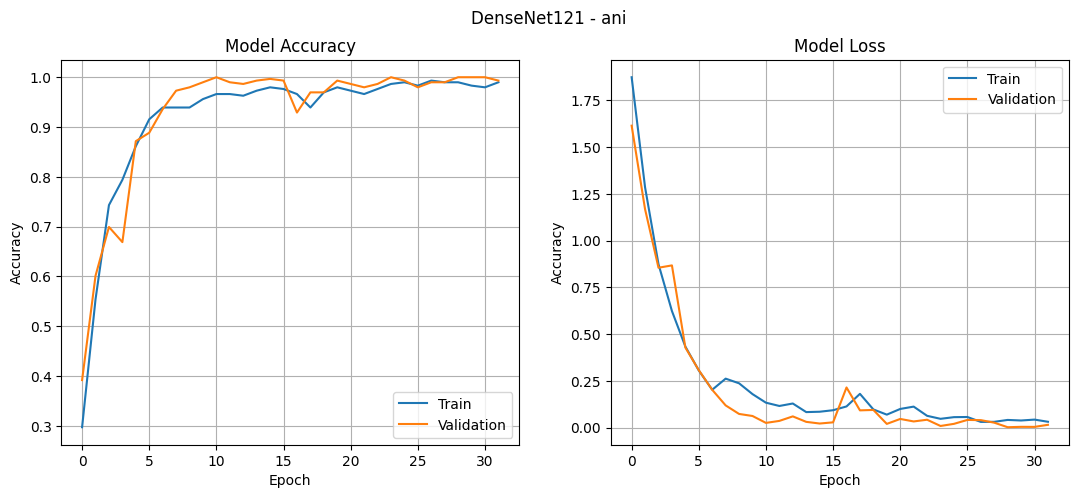

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title = 'DenseNet121 - ani')

##**B-1.6. DenseNet201**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_densenet201'

In [ ]:
base_model=DenseNet201(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-41-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8520 - accuracy: 0.3007
Epoch 1: loss improved from inf to 1.85200, saving model to TransferLearning/ani_densenet201.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 136s 1s/step - loss: 1.8520 - accuracy: 0.3007 - val_loss: 1.8132 - val_accuracy: 0.3885
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.0850 - accuracy: 0.6351
Epoch 2: loss improved from 1.85200 to 1.08500, saving model to TransferLearning/ani_densenet201.h5
25/25 [==============================] - 24s 1s/step - loss: 1.0850 - accuracy: 0.6351 - val_loss: 1.2821 - val_accuracy: 0.5203
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.7736
Epoch 3: loss improved from 1.08500 to 0.67384, saving model to TransferLearning/ani_densenet201.h5
25/25 [==============================] - 30s 1s/step - loss: 0.6738 - accuracy: 0.7736 - val_loss: 1.1894 - val_accuracy: 0.5980
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3761 - accuracy: 0.8953
Epoch 4: loss improved from 0.67384 to 0.37605, saving model to TransferLearning/ani_densenet201.h5
25/25 [=======================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_5  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1024)              1967104   
                                                                 
 dense_11 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 20296263 (77.42 MB)
Trainable params: 20067207 (76.55 MB)
Non-trainable params: 229056 (894.75 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 201s 8s/step - loss: 0.0351 - accuracy: 0.9899
Accuracy is 98.98648858070374%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 226ms/step - loss: 0.0166 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 254ms/step - loss: 0.0510 - accuracy: 0.9764
Accuracy is 97.63513803482056%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 5s 200ms/step - loss: 0.0259 - accuracy: 0.9932
Accuracy is 99.32432174682617%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 235ms/step - loss: 0.0655 - accuracy: 0.9797
Accuracy is 97.972971200943%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

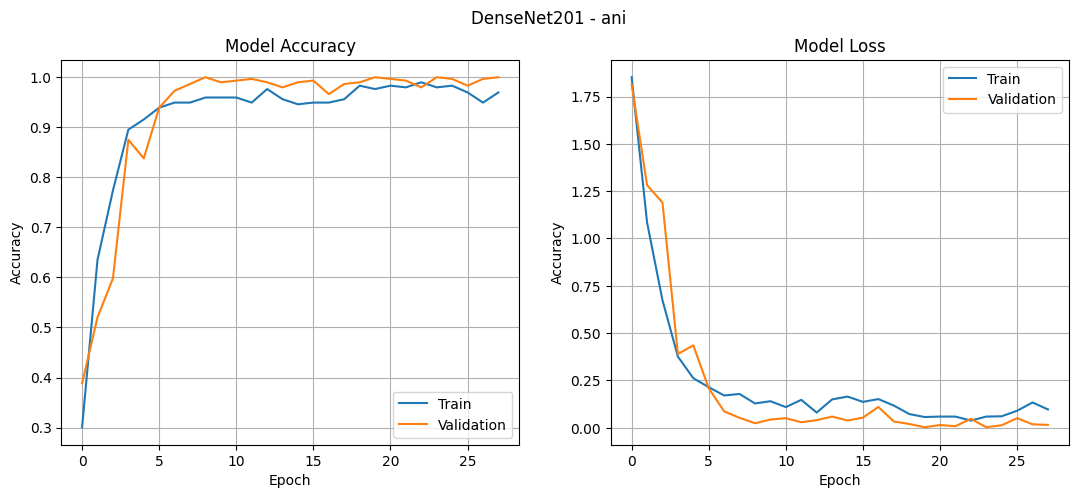

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='DenseNet201 - ani')

##**B-1.7. NASNetLarge**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_nasnetlarge'

In [ ]:
base_model=NASNetLarge(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-32-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8105 - accuracy: 0.3311
Epoch 1: loss improved from inf to 1.81047, saving model to TransferLearning/ani_nasnetlarge.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 278s 4s/step - loss: 1.8105 - accuracy: 0.3311 - val_loss: 1.6710 - val_accuracy: 0.3547
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.3244 - accuracy: 0.5034
Epoch 2: loss improved from 1.81047 to 1.32442, saving model to TransferLearning/ani_nasnetlarge.h5
25/25 [==============================] - 114s 5s/step - loss: 1.3244 - accuracy: 0.5034 - val_loss: 1.5322 - val_accuracy: 0.4662
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.7061
Epoch 3: loss improved from 1.32442 to 0.95657, saving model to TransferLearning/ani_nasnetlarge.h5
25/25 [==============================] - 158s 7s/step - loss: 0.9566 - accuracy: 0.7061 - val_loss: 1.4741 - val_accuracy: 0.5270
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.8243
Epoch 4: loss improved from 0.95657 to 0.55753, saving model to TransferLearning/ani_nasnetlarge.h5
25/25 [=====================

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d_6  (None, 4032)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 1024)              4129792   
                                                                 
 dense_13 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 89053785 (339.71 MB)
Trainable params: 88857117 (338.96 MB)
Non-trainable params: 196668 (768.23 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 16s 282ms/step - loss: 0.2641 - accuracy: 0.9155
Accuracy is 91.55405163764954%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 239ms/step - loss: 0.2100 - accuracy: 0.9324
Accuracy is 93.24324131011963%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 7s 269ms/step - loss: 0.1904 - accuracy: 0.9324
Accuracy is 93.24324131011963%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 222ms/step - loss: 0.2328 - accuracy: 0.9223
Accuracy is 92.22972989082336%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 7s 269ms/step - loss: 0.1776 - accuracy: 0.9426
Accuracy is 94.25675868988037%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

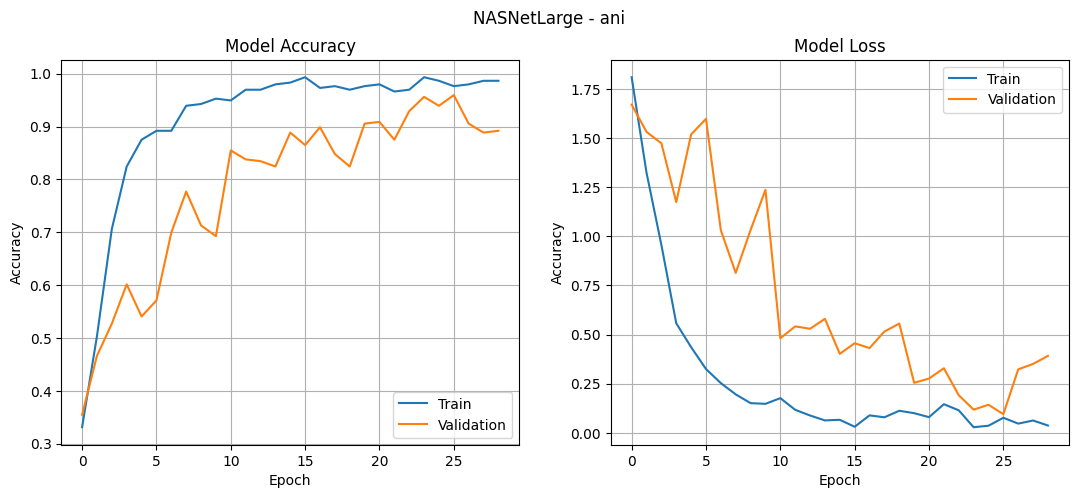

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='NASNetLarge - ani')

##**B-1.8. EfficientNetV2L**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 296 images belonging to 7 classes.
Found 296 images belonging to 7 classes.


* **Model Setting**

In [ ]:
model_name='ani_efficientnetv2l'

In [ ]:
base_model=EfficientNetV2L(include_top=False, weights='imagenet',input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-25-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 1.8474 - accuracy: 0.2872
Epoch 1: loss improved from inf to 1.84738, saving model to TransferLearning/ani_efficientnetv2l.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 346s 6s/step - loss: 1.8474 - accuracy: 0.2872 - val_loss: 1.5002 - val_accuracy: 0.5068
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.3634 - accuracy: 0.5473
Epoch 2: loss improved from 1.84738 to 1.36337, saving model to TransferLearning/ani_efficientnetv2l.h5
25/25 [==============================] - 97s 4s/step - loss: 1.3634 - accuracy: 0.5473 - val_loss: 0.9811 - val_accuracy: 0.7297
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.8839 - accuracy: 0.7568
Epoch 3: loss improved from 1.36337 to 0.88386, saving model to TransferLearning/ani_efficientnetv2l.h5
25/25 [==============================] - 96s 4s/step - loss: 0.8839 - accuracy: 0.7568 - val_loss: 0.4194 - val_accuracy: 0.9426
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.5486 - accuracy: 0.8378
Epoch 4: loss improved from 0.88386 to 0.54858, saving model to TransferLearning/ani_efficientnetv2l.h5
25/25 [===========

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 7, 7, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_15 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 119065767 (454.20 MB)
Trainable params: 118553191 (452.24 MB)
Non-trainable params: 512576 (1.96 MB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 296 images belonging to 7 classes.
25/25 [==============================] - 21s 289ms/step - loss: 0.0107 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 219ms/step - loss: 0.0202 - accuracy: 0.9932
Accuracy is 99.32432174682617%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 246ms/step - loss: 0.0203 - accuracy: 0.9899
Accuracy is 98.98648858070374%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 221ms/step - loss: 0.0247 - accuracy: 0.9966
Accuracy is 99.66216087341309%
Found 296 images belonging to 7 classes.
25/25 [==============================] - 6s 220ms/step - loss: 0.0044 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

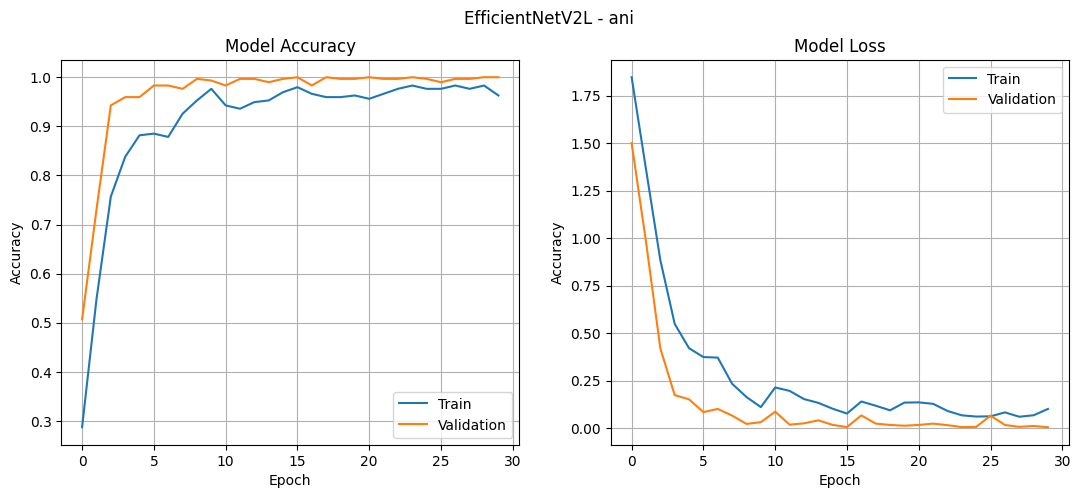

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='EfficientNetV2L - ani')

##**B-1.F. Model Comparison**

In [ ]:
hists=[]
for m in models:
    hists.append(get_hist(model_name=f'{data_name}_{m}'))

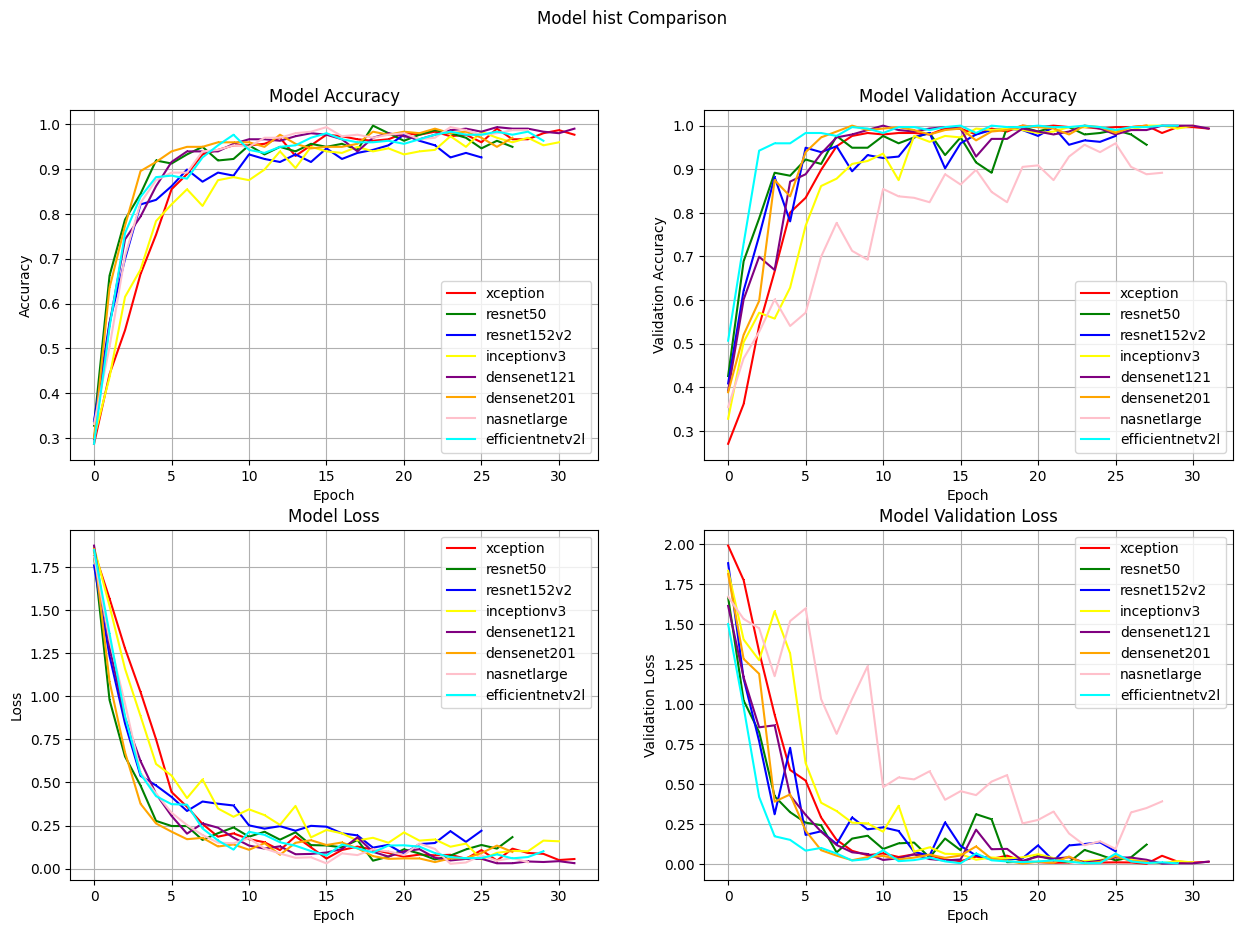

In [ ]:
show_model_comparison(hist_list=hists, color_list=colors, model_list=models, data_name=data_name)

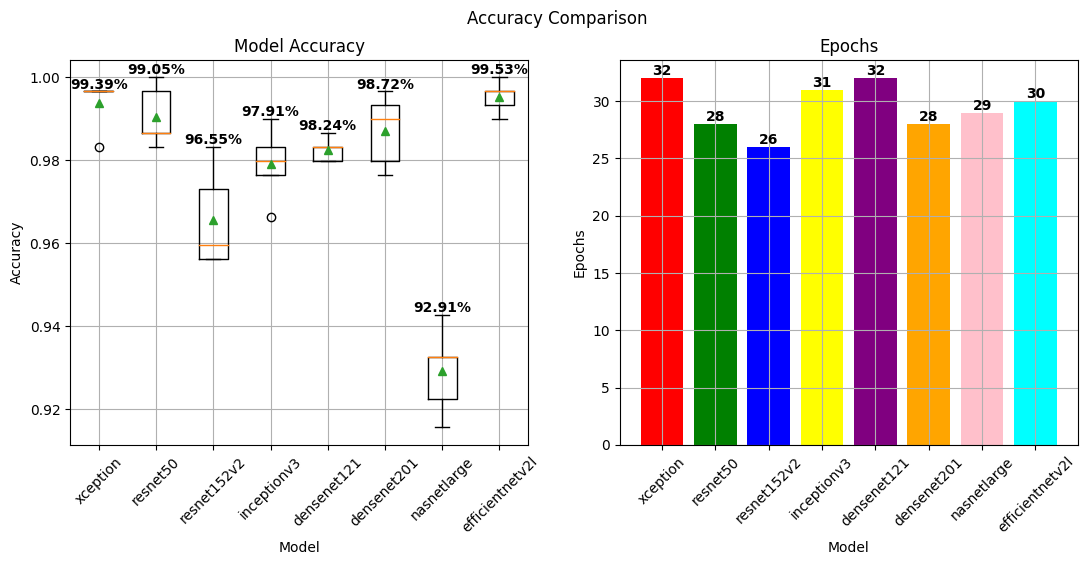

In [ ]:
show_accuracy_comparison(data_name=data_name, model_list=models, color_list=colors, hist_list=hists)

#**C. Snack**

In [ ]:
train_dir = 'snack/train'
val_dir = 'snack/val'
data_name='snack'

In [ ]:
images_size=224
class_number=8

##**C.1. Xception**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.xception import Xception, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 790 images belonging to 8 classes.
Found 578 images belonging to 8 classes.


* **Model Setting**

In [ ]:
model_name='snack_xception'

In [ ]:
base_model=Xception(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

83683744/83683744 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-24-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.8515 - accuracy: 0.7759
Epoch 1: loss improved from inf to 0.85148, saving model to TransferLearning/snack_xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 646s 9s/step - loss: 0.8515 - accuracy: 0.7759 - val_loss: 1.4564 - val_accuracy: 0.6194
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.9835
Epoch 2: loss improved from 0.85148 to 0.08578, saving model to TransferLearning/snack_xception.h5
66/66 [==============================] - 106s 2s/step - loss: 0.0858 - accuracy: 0.9835 - val_loss: 0.5018 - val_accuracy: 0.8304
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9924
Epoch 3: loss improved from 0.08578 to 0.03810, saving model to TransferLearning/snack_xception.h5
66/66 [==============================] - 100s 2s/step - loss: 0.0381 - accuracy: 0.9924 - val_loss: 0.4365 - val_accuracy: 0.8720
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9937
Epoch 4: loss improved from 0.03810 to 0.02134, saving model to TransferLearning/snack_xception.h5
66/66 [========================

* **Assessment**

In [ ]:
get_cnn(model_name, new_cnn=cnn)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 22967856 (87.62 MB)
Trainable params: 22913328 (87.41 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 790 images belonging to 8 classes.
66/66 [==============================] - 71s 1s/step - loss: 2.9426e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 54s 815ms/step - loss: 1.8028e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 54s 821ms/step - loss: 1.4970e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 52s 780ms/step - loss: 2.5943e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 51s 772ms/step - loss: 2.1883e-05 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

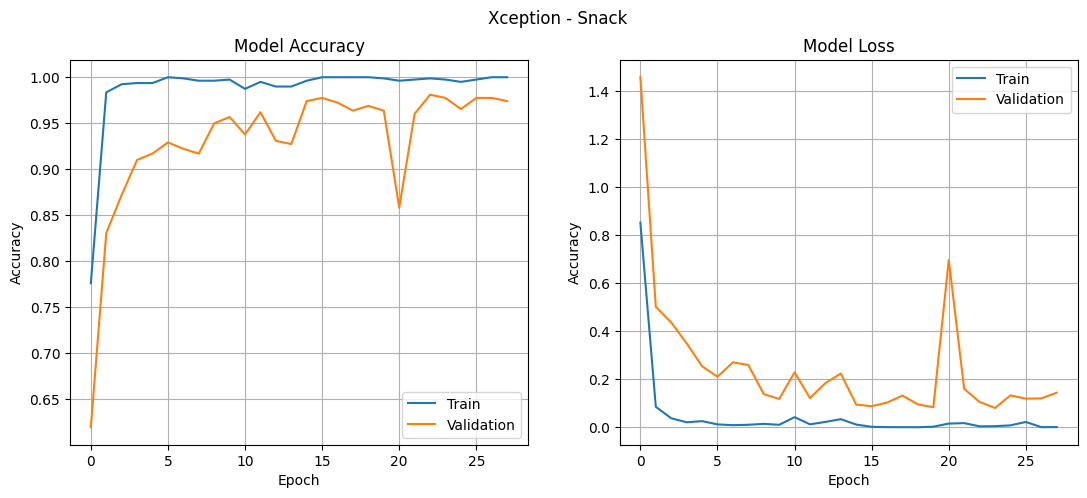

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='Xception - Snack',)

##**C.2. ResNet50**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 790 images belonging to 8 classes.
Found 578 images belonging to 8 classes.


* **Model Setting**

In [ ]:
model_name='snack_resnet50'

In [ ]:
base_model=ResNet50(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

94765736/94765736 [==============================] - 0s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-35-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.3564 - accuracy: 0.8987
Epoch 1: loss improved from inf to 0.35644, saving model to TransferLearning/snack_resnet50.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 137s 1s/step - loss: 0.3564 - accuracy: 0.8987 - val_loss: 1.2663 - val_accuracy: 0.7785
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.0436 - accuracy: 0.9861
Epoch 2: loss improved from 0.35644 to 0.04360, saving model to TransferLearning/snack_resnet50.h5
66/66 [==============================] - 99s 2s/step - loss: 0.0436 - accuracy: 0.9861 - val_loss: 0.8444 - val_accuracy: 0.9031
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9861
Epoch 3: loss did not improve from 0.04360
66/66 [==============================] - 98s 1s/step - loss: 0.0538 - accuracy: 0.9861 - val_loss: 0.3853 - val_accuracy: 0.8997
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9797
Epoch 4: loss did not improve from 0.04360
66/66 [==============================] - 94s 1s/step - loss: 0.0718 - accuracy: 0.9797 - val_loss: 0.1541 - val_accuracy: 0.9516
Epoch 5/50
66/66

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 25694088 (98.02 MB)
Trainable params: 25640968 (97.81 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 790 images belonging to 8 classes.
66/66 [==============================] - 64s 966ms/step - loss: 3.0470e-06 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 58s 865ms/step - loss: 1.5173e-06 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 54s 816ms/step - loss: 1.5454e-06 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 51s 780ms/step - loss: 1.6025e-06 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 51s 771ms/step - loss: 2.1556e-06 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

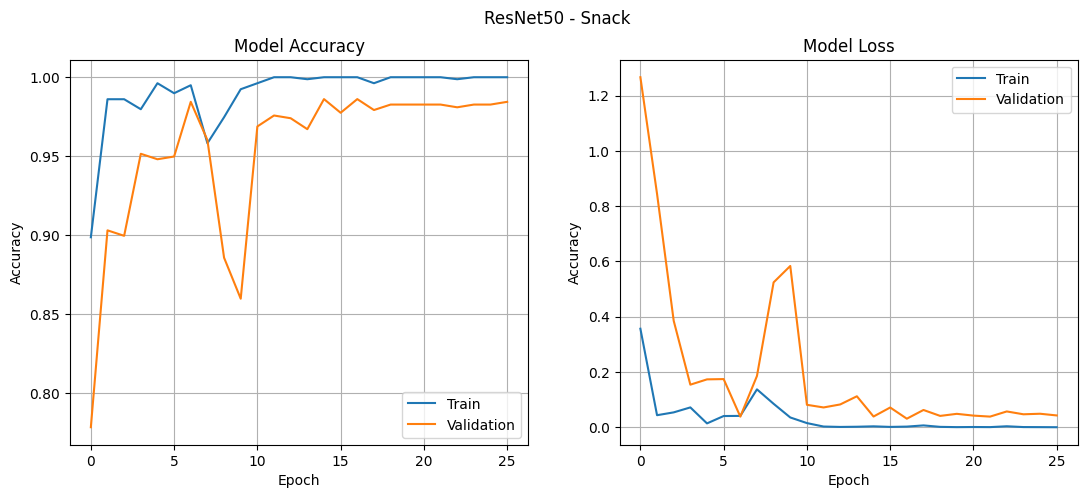

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet50 - Snack')

##**C.3. ResNet152V2**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 790 images belonging to 8 classes.
Found 578 images belonging to 8 classes.


* **Model Setting**

In [ ]:
model_name='snack_resnet152v2'

In [ ]:
base_model=ResNet152V2(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

234545216/234545216 [==============================] - 3s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-28-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9228
Epoch 1: loss improved from inf to 0.26865, saving model to TransferLearning/snack_resnet152v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 691s 9s/step - loss: 0.2686 - accuracy: 0.9228 - val_loss: 0.5137 - val_accuracy: 0.8668
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9785
Epoch 2: loss improved from 0.26865 to 0.08308, saving model to TransferLearning/snack_resnet152v2.h5
66/66 [==============================] - 100s 2s/step - loss: 0.0831 - accuracy: 0.9785 - val_loss: 0.5994 - val_accuracy: 0.8979
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0674 - accuracy: 0.9823
Epoch 3: loss improved from 0.08308 to 0.06737, saving model to TransferLearning/snack_resnet152v2.h5
66/66 [==============================] - 118s 2s/step - loss: 0.0674 - accuracy: 0.9823 - val_loss: 0.5973 - val_accuracy: 0.8270
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9785
Epoch 4: loss did not improve from 0.06737
66/66 [==============================] - 86s 1s/step - loss: 0.0713 - accuracy: 0

* **Assessment**

In [ ]:
get_cnn(model_name=model_name, new_cnn=cnn)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_3 (Dense)             (None, 8)                 8200      
                                                                 
Total params: 60438024 (230.55 MB)
Trainable params: 60294280 (230.00 MB)
Non-trainable params: 143744 (561.50 KB)
_________________________________________________________________


In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 790 images belonging to 8 classes.
66/66 [==============================] - 49s 732ms/step - loss: 5.0354e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 46s 698ms/step - loss: 3.4929e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 46s 692ms/step - loss: 6.1545e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 47s 708ms/step - loss: 1.1522e-04 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 46s 702ms/step - loss: 3.4501e-05 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

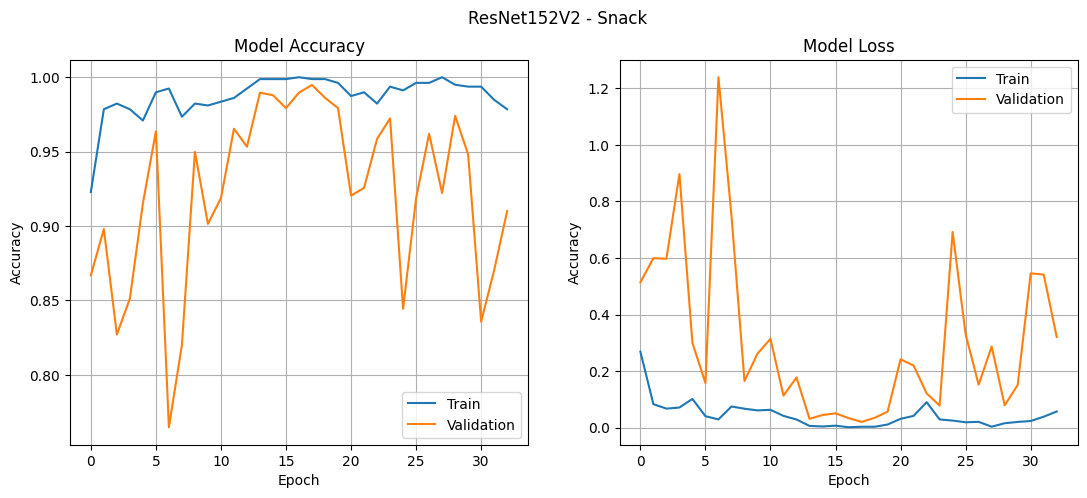

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='ResNet152V2 - Snack')

##**C.4. InceptionV3**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

Found 790 images belonging to 8 classes.
Found 578 images belonging to 8 classes.


* **Model Setting**

In [ ]:
model_name='snack_inceptionv3'

In [ ]:
base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

87910968/87910968 [==============================] - 1s 0us/step


* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn=compile_model(based_model=base_model, classes_num=class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

<ipython-input-51-ce471f47c524>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.7835
Epoch 1: loss improved from inf to 0.70479, saving model to TransferLearning/snack_inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 127s 1s/step - loss: 0.7048 - accuracy: 0.7835 - val_loss: 1.1387 - val_accuracy: 0.6834
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.0812 - accuracy: 0.9823
Epoch 2: loss improved from 0.70479 to 0.08123, saving model to TransferLearning/snack_inceptionv3.h5
66/66 [==============================] - 92s 1s/step - loss: 0.0812 - accuracy: 0.9823 - val_loss: 0.4091 - val_accuracy: 0.8668
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9734
Epoch 3: loss did not improve from 0.08123
66/66 [==============================] - 75s 1s/step - loss: 0.0868 - accuracy: 0.9734 - val_loss: 0.2811 - val_accuracy: 0.8945
Epoch 4/50
66/66 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9861
Epoch 4: loss improved from 0.08123 to 0.04727, saving model to TransferLearning/snack_inceptionv3.h5
66/66 [==============================] - 86s 1s/step - loss: 0.0473 - accuracy: 0.9

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

Found 790 images belonging to 8 classes.
66/66 [==============================] - 46s 690ms/step - loss: 8.0617e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 47s 706ms/step - loss: 4.0621e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 46s 698ms/step - loss: 4.5972e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 45s 679ms/step - loss: 4.6686e-05 - accuracy: 1.0000
Accuracy is 100.0%
Found 790 images belonging to 8 classes.
66/66 [==============================] - 46s 689ms/step - loss: 7.2167e-05 - accuracy: 1.0000
Accuracy is 100.0%


In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

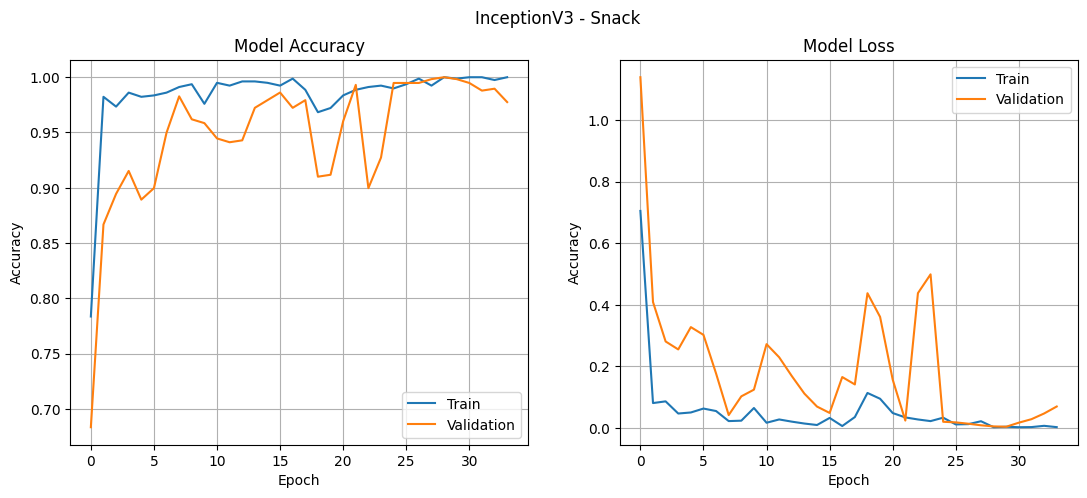

In [ ]:
hist=get_hist(model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='InceptionV3 - Snack')

##**C.5. DenseNet121**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

* **Model Setting**

In [ ]:
model_name='snack_densenet121'

In [ ]:
base_model=DenseNet121(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title = 'DenseNet121 - Snack')

##**C.6. DenseNet201**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

* **Model Setting**

In [ ]:
model_name='snack_densenet201'

In [ ]:
base_model=DenseNet201(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='DenseNet201 - Snack')

##**C.7. NASNetLarge**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.nasnet import NASNetLarge, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

* **Model Setting**

In [ ]:
model_name='snack_nasnetlarge'

In [ ]:
base_model=NASNetLarge(weights='imagenet',include_top=False,input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='NASNetLarge - Snack')

##**C.8. EfficientNetV2L**

* **Image Generation**

In [ ]:
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L, preprocess_input as ppinput

train_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
validation_generator = image_gen_no_aug(pp_input = ppinput, data_dir=val_dir, image_size = images_size)

* **Model Setting**

In [ ]:
model_name='snack_efficientnetv2l'

In [ ]:
base_model=EfficientNetV2L(include_top=False, weights='imagenet',input_shape=(images_size,images_size,3))

* **Model compile and train**

In [ ]:
callback=set_callback(model_name)
cnn = compile_model(based_model = base_model, classes_num = class_number)

In [ ]:
hist=cnn.fit_generator(train_generator, epochs=50, validation_data=validation_generator, verbose=1, callbacks=callback)

* **Assessment**

In [ ]:
#get_cnn(model_name=model_name, new_cnn=cnn)

In [ ]:
res=[]

for i in range(5):
    valid_generator = image_gen_with_aug(pp_input = ppinput, data_dir=train_dir, image_size = images_size)
    acc=cnn.evaluate(valid_generator, verbose=1)
    print(f"Accuracy is {acc[1]*100}%")
    res.append(acc[1])

In [ ]:
save_validations(data_name=data_name,model_name=model_name, result=res)

In [ ]:
hist=get_hist(model_name=model_name)
show_hist_graph(fit_hist = hist, model_name=model_name, fig_size = (13, 5), title ='EfficientNetV2L - Snack')

##**C.F. Model Comparison**

In [ ]:
hists=[]
for m in models:
    hists.append(get_hist(model_name=f'{data_name}_{m}'))

In [ ]:
show_model_comparison(hist_list=hists, color_list=colors, model_list=models, data_name=data_name)

In [ ]:
show_accuracy_comparison(data_name=data_name, model_list=models, color_list=colors, hist_list=hists)